## Data / Package Import 

In [2]:
import pandas as pd
import os
from Bio import Affy
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM, GRU, Layer, Add, GlobalAveragePooling1D, Conv1D, ReLU
from sklearn.model_selection import KFold, cross_val_predict
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve
import tensorflow as tf
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, Dropout, Activation, LeakyReLU, Reshape
from tensorflow.keras.callbacks import LearningRateScheduler
import seaborn as sns
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV, cross_val_score
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval
from hyperopt.pyll.base import scope
import scipy.stats as stats
from keras.layers import Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras import backend as K
from transformers import BertTokenizer
import torch
from torch.utils.data import Dataset
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from accelerate import DataLoaderConfiguration
import optuna
from optuna.integration import TFKerasPruningCallback
from tensorflow.keras.regularizers import l1
from bayes_opt import BayesianOptimization
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from boruta import BorutaPy
from sklearn.feature_selection import mutual_info_classif, SelectKBest
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from skrebate import ReliefF
from sklearn.feature_selection import mutual_info_classif, RFE
from sklearn.svm import SVC

## AMGM and Cosine Feature Selection

In [2]:
def calculate_amgm(X):
    """
    Calculate AMGM for each feature (row) in the dataset X.
    
    Parameters:
    X (numpy array): The input data array with shape (n_features, n_samples)
    
    Returns:
    amgm_values (numpy array): The AMGM values for each feature (row)
    """
    N = X.shape[1]
    
    exp_X = np.exp(X)
    amgm_values = (np.mean(exp_X, axis=1)) / (np.exp(np.mean(X, axis=1)))
    
    return amgm_values

In [3]:
def filter_redundant_features(X, relevant_indices, threshold=0.9):
    relevant_features = X[relevant_indices, :]
    cos_sim_matrix = cosine_similarity(relevant_features)
    
    to_keep = []
    to_drop = set()
    for i in range(cos_sim_matrix.shape[0]):
        if i not in to_drop:
            to_keep.append(relevant_indices[i])
            for j in range(i + 1, cos_sim_matrix.shape[0]):
                if cos_sim_matrix[i, j] > threshold:
                    to_drop.add(relevant_indices[j])
    return to_keep

## Autoencoder Feature Selection with Lasso Regression

In [51]:
def create_feature_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(encoding_dim, activation='relu')(input_layer)  # Encoder part
    decoded = Dense(input_dim, activation='sigmoid')(encoded)  # Decoder part
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    encoder = Model(inputs=input_layer, outputs=encoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder, encoder

In [52]:
def apply_l1_feature_selection(X, y, alpha=0.01, target_features=100):
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    model = SelectFromModel(lasso, prefit=True, max_features=target_features)
    X_reduced = model.transform(X)
    selected_indices = model.get_support(indices=True)
    return X_reduced, selected_indices

## Initial Deep Autoencoder

In [4]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [5]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [6]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv' #Change for different files

In [7]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_34732\562430524.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [8]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [9]:
amgm_values = calculate_amgm(X)

In [10]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [11]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [108788 155109  90362  55483  70311  89251 152481  87579 134951 157594]
Top AMGM values: [1.00239526 1.00239538 1.00239567 1.00239568 1.00239665 1.00239665
 1.00239745 1.00239801 1.00239812 1.00239898]


In [12]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [13]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [14]:
X_selected = X[selected_indices, :].T 

In [15]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [18]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │           1,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,826 (50.10 KB)

 Trainable params: 12,826 (50.10 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6679 - loss: 0.6637 - val_accuracy: 0.5833 - val_loss: 0.7048 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6972 - loss: 0.6055 - val_accuracy: 0.5833 - val_loss: 0.6858 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6475 - loss: 0.6488 - val_accuracy: 0.5833 - val_loss: 0.6792 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7017 - loss: 0.6196 - val_accuracy: 0.5833 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6344 - loss: 0.6775 - val_accuracy: 0.5833 - val_loss: 0.6745 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7001 - loss: 0.6171 - val_accuracy: 0.5833 - val_loss: 0.6893 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6498 - loss: 0.6345 - val_accuracy: 0.5833 - val_

In [21]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.9166666666666666
F1 Score: 0.88


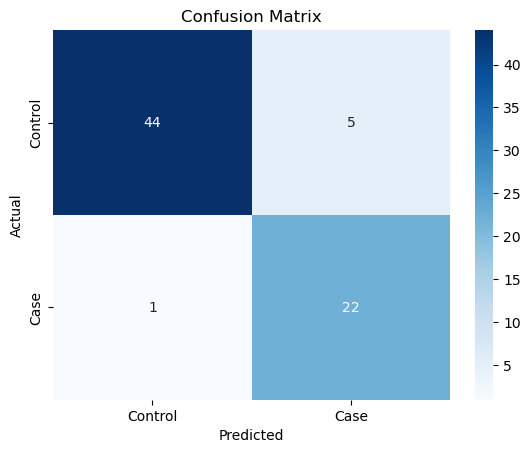

In [22]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [23]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Accuracy: 0.9166666666666666
F1 Score: 0.88
Specificity: 0.8979591836734694
Sensitivity: 0.9565217391304348


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization)

In [24]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_34732\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [25]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [26]:
amgm_values = calculate_amgm(X)

In [27]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [28]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [108788 155109  90362  55483  70311  89251 152481  87579 134951 157594]
Top AMGM values: [1.00239526 1.00239538 1.00239567 1.00239568 1.00239665 1.00239665
 1.00239745 1.00239801 1.00239812 1.00239898]


In [29]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [30]:
X_selected = X[selected_indices, :].T

In [31]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [32]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values  

In [33]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [34]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [35]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [36]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000226700FC180> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.8638888888888889, F1 Score: 0.8, Sensitivity: 0.8166666666666667, Specificity: 0.8875                      
Accuracy: 0.9, F1 Score: 0.84873949

In [37]:
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best Accuracy: 0.9055555555555556
Best F1 Score: 0.8571428571428571
Best Specificity: 0.9333333333333333
Best Sensitivity: 0.85


In [38]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_505 (Dense)                    │ (None, 64)                  │           6,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_202 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_506 (Dense)                    │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_507 (Dense)                    │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_508 (Dense)                    │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_509 (Dense)                    │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,257 (67.41 KB)

 Trainable params: 17,257 (67.41 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 64
Neurons in second layer: 32
Dropout rate: 0.3180760504260577
Learning rate: 0.0005362880189699868
Number of epochs: 150
Batch size: 112


## Bidirectional LSTM with Bayesian Optimization

In [54]:
def create_rnn_model(input_shape, units=64, bidirectional=False, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [55]:
Input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_34732\1299816614.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [56]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [57]:
amgm_values = calculate_amgm(X)

In [58]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [59]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [108788 155109  90362  55483  70311  89251 152481  87579 134951 157594]
Top AMGM values: [1.00239526 1.00239538 1.00239567 1.00239568 1.00239665 1.00239665
 1.00239745 1.00239801 1.00239812 1.00239898]


In [60]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [61]:
X_selected = X[selected_indices, :].T

In [62]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [63]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

In [64]:
space = {
    'units': scope.int(hp.quniform('units', 32, 128, 32)),  # Reduced range for faster evaluation
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),  # Reduced range
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Adjusted range
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),  # Reduced number of epochs
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),  # Reduced range
    'bidirectional': hp.choice('bidirectional', [True, False])
}

In [65]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = KerasClassifier(
            model=create_rnn_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            bidirectional=params['bidirectional'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
        specificity = tn / (tn + fp)  # True Negative Rate

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [66]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)

Iteration Results - Accuracy: 0.9375, F1 Score: 0.9118515273179105, Sensitivity: 0.941675101214575, Specificity: 0.9373152709359607
Iteration Results - Accuracy: 0.9270833333333334, F1 Score: 0.8915798366657279, Sensitivity: 0.8769821187584346, Specificity: 0.9592261904761905
Iteration Results - Accuracy: 0.7291666666666666, F1 Score: 0.3057644110275689, Sensitivity: 0.22199730094466938, Specificity: 0.9752052545155993
Iteration Results - Accuracy: 0.9305555555555555, F1 Score: 0.8925976179707522, Sensitivity: 0.8585526315789473, Specificity: 0.9752976190476191
Iteration Results - Accuracy: 0.9166666666666666, F1 Score: 0.8765867631539273, Sensitivity: 0.8706140350877193, Specificity: 0.9487171592775042
Iteration Results - Accuracy: 0.9166666666666666, F1 Score: 0.8765867631539273, Sensitivity: 0.8706140350877193, Specificity: 0.9487171592775042
Iteration Results - Accuracy: 0.9131944444444443, F1 Score: 0.8662807318467696, Sensitivity: 0.8362010796221323, Specificity: 0.95913382594417

In [67]:
best_params = {
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
    'bidirectional': best['bidirectional']
}

print("Best Hyperparameters:", best_params)

# Build and summarize the best model
best_model = create_rnn_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    bidirectional=best_params['bidirectional'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


Best Hyperparameters: {'units': 96, 'dropout_rate': 0.4005748681755499, 'learning_rate': 0.00018567950581743775, 'epochs': 40, 'batch_size': 32, 'bidirectional': 1}


In [68]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step

Test Performance:
Accuracy: 0.9027777777777778
F1 Score: 0.8292682926829268
Sensitivity: 0.7083333333333334
Specificity: 1.0


## Gru with Bayesian Optimization

In [72]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [86]:
def create_gru_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [75]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_34732\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [76]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [77]:
amgm_values = calculate_amgm(X)

In [78]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [79]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [80]:
X_selected = X[selected_indices, :].T

In [81]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [88]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [91]:
space = {
    'units': scope.int(hp.quniform('units', 32, 64, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.4),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 20, 30, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [92]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        model = KerasClassifier(
            model=create_gru_model,
            input_shape=(X_selected.shape[1], 1),
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_val_pred = model.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)
    
    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")
    
    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [93]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

Iteration Results - Accuracy: 0.8993055555555555, F1 Score: 0.8415123320041352, Sensitivity: 0.8054741554741556, Specificity: 0.947462919594067
Iteration Results - Accuracy: 0.8784722222222223, F1 Score: 0.8036716632461314, Sensitivity: 0.7251933251933251, Specificity: 0.956895654436638
Iteration Results - Accuracy: 0.71875, F1 Score: 0.3816260803838443, Sensitivity: 0.25905575905575906, Specificity: 0.9527452511059069
Iteration Results - Accuracy: 0.9270833333333334, F1 Score: 0.8883347141673571, Sensitivity: 0.8643264143264143, Specificity: 0.9575982305490501
Iteration Results - Accuracy: 0.71875, F1 Score: 0.33640949920019686, Sensitivity: 0.21526251526251527, Specificity: 0.9794561540463179
Iteration Results - Accuracy: 0.7430555555555557, F1 Score: 0.38940914158305456, Sensitivity: 0.26465201465201466, Specificity: 0.9787535779339058
Iteration Results - Accuracy: 0.8784722222222222, F1 Score: 0.7829273271299767, Sensitivity: 0.7301587301587302, Specificity: 0.9410226385636221
Iter

In [94]:
best_params = space_eval(space, best)
print("Best Parameters:", best_params)

Best Parameters: {'batch_size': 48, 'dropout_rate': 0.3407991766385944, 'epochs': 20, 'learning_rate': 0.0014358443126774572, 'units': 64}


In [95]:
best_model = create_gru_model(
    input_shape=(X_selected.shape[1], 1),
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [96]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [97]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [98]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step

Test Performance:
Accuracy: 0.9583333333333334
F1 Score: 0.9333333333333333
Sensitivity: 0.9130434782608695
Specificity: 0.9795918367346939


## CNN with Bayesian Optimization

In [100]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_34732\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [101]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [102]:
amgm_values = calculate_amgm(X)

In [103]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [104]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [105]:
X_selected = X[selected_indices, :].T

In [106]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [107]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [108]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [109]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [110]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [111]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [112]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                

Iteration Results - Accuracy: 0.8541666666666666, F1 Score: 0.7173160173160174, Sensitivity: 0.6804436304436304, Specificity: 0.9547619047619046
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                         

In [113]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 48, 'dropout_rate': 0.24622116646733508, 'epochs': 40, 'filters': 96, 'kernel_size': 2, 'learning_rate': 0.00343029049033311}


In [114]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [115]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [116]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [117]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.8333333333333334
F1 Score: 0.7931034482758621
Sensitivity: 1.0
Specificity: 0.7551020408163265


## ResNet

In [121]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_34732\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [122]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [123]:
amgm_values = calculate_amgm(X)

In [124]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [125]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [126]:
X_selected = X[selected_indices, :].T

In [127]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [128]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [130]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', strides=1)(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters, kernel_size, padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [131]:
def create_resnet_model(input_shape, filters=64, num_blocks=6, kernel_size=3, dropout_rate=0.5, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size=kernel_size)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [132]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'num_blocks': scope.int(hp.quniform('num_blocks', 4, 10, 2)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 3, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),
    'epochs': scope.int(hp.quniform('epochs', 20, 50, 10))
}

In [133]:
def objective(params):
    print(f"Trying params: {params}")
    filters = params['filters']
    num_blocks = params['num_blocks']
    kernel_size = params['kernel_size']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Create the ResNet model
    model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                filters=filters,
                                num_blocks=num_blocks,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Filters: {filters}, Blocks: {num_blocks}, Kernel Size: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [134]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Adjust the number of evaluations
            trials=trials)

Trying params: {'batch_size': 48, 'dropout_rate': 0.34620950493860636, 'epochs': 30, 'filters': 96, 'kernel_size': 3, 'learning_rate': 0.0002461006851563884, 'num_blocks': 6}
Iteration - Loss: 0.36932194232940674, Filters: 96, Blocks: 6, Kernel Size: 3, Dropout: 0.34620950493860636, LR: 0.0002461006851563884, Batch Size: 48, Epochs: 30
Trying params: {'batch_size': 48, 'dropout_rate': 0.3250065081221475, 'epochs': 30, 'filters': 32, 'kernel_size': 5, 'learning_rate': 0.0007564069332389905, 'num_blocks': 4}
Iteration - Loss: 0.2577812075614929, Filters: 32, Blocks: 4, Kernel Size: 5, Dropout: 0.3250065081221475, LR: 0.0007564069332389905, Batch Size: 48, Epochs: 30
Trying params: {'batch_size': 16, 'dropout_rate': 0.49299517666600096, 'epochs': 20, 'filters': 128, 'kernel_size': 4, 'learning_rate': 0.00017187162113472483, 'num_blocks': 6}
Iteration - Loss: 0.5442283153533936, Filters: 128, Blocks: 6, Kernel Size: 4, Dropout: 0.49299517666600096, LR: 0.00017187162113472483, Batch Size: 1

In [135]:
best_params = space_eval(space, best)
print(f"Best parameters: {best_params}")

Best parameters: {'batch_size': 32, 'dropout_rate': 0.4008150712120807, 'epochs': 40, 'filters': 128, 'kernel_size': 4, 'learning_rate': 0.007349090037444459, 'num_blocks': 8}


In [136]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                 filters=best_params['filters'],
                                 num_blocks=best_params['num_blocks'],
                                 kernel_size=best_params['kernel_size'],
                                 dropout_rate=best_params['dropout_rate'],
                                 learning_rate=best_params['learning_rate'])

In [137]:
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 758ms/step - accuracy: 0.6927 - loss: 0.8888 - val_accuracy: 0.2414 - val_loss: 569302.4375
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 759ms/step - accuracy: 0.8986 - loss: 0.2779 - val_accuracy: 0.2414 - val_loss: 21561.8047
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 742ms/step - accuracy: 0.9347 - loss: 0.1760 - val_accuracy: 0.2414 - val_loss: 2424.2161
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 692ms/step - accuracy: 0.9199 - loss: 0.2526 - val_accuracy: 0.2414 - val_loss: 374.0674
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 604ms/step - accuracy: 0.9026 - loss: 0.2442 - val_accuracy: 0.2414 - val_loss: 71.9696
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 737ms/step - accuracy: 0.9448 - loss: 0.1706 - val_accuracy: 0.2414 - val_loss: 46.9400
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 749ms/step - accuracy: 0.9223 - loss: 0.2058 - val_accuracy: 0.2414 - val_loss: 18.4440
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 767ms/step - accuracy: 0.9256 - loss: 0.2400 - val_accuracy: 0

In [138]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


In [139]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.8333333333333334
F1 Score: 0.6470588235294118
Sensitivity: 0.4782608695652174
Specificity: 1.0


## FNN with Bayesian Optimization

In [140]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_34732\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [141]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [142]:
amgm_values = calculate_amgm(X)

In [143]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [144]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [145]:
X_selected = X[selected_indices, :].T

In [146]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [147]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [149]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [150]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [151]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [152]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.3805123269557953, Params: {'batch_size': 64, 'dropout_rate': 0.2116637388620488, 'epochs': 140, 'learning_rate': 3.4000936857384964e-05, 'num_layers': 2, 'units': 224}
Iteration - Loss: 0.6364403367042542, Params: {'batch_size': 32, 'dropout_rate': 0.3983660346898028, 'epochs': 90, 'learning_rate': 0.0002463129973412488, 'num_layers': 5, 'units': 192}
Iteration - Loss: 0.29175928235054016, Params: {'batch_size': 96, 'dropout_rate': 0.2902207517552262, 'epochs': 140, 'learning_rate': 0.00017018688590673793, 'num_layers': 2, 'units': 128}
Iteration - Loss: 0.42567870020866394, Params: {'batch_size': 32, 'dropout_rate': 0.22986034380782852, 'epochs': 90, 'learning_rate': 6.538160271295665e-05, 'num_layers': 5, 'units': 96}
Iteration - Loss: 0.2616903483867645, Params: {'batch_size': 64, 'dropout_rate': 0.18165950780487022, 'epochs': 130, 'learning_rate': 0.0001879592675187718, 'num_layers': 3, 'units': 224}
Iteration - Loss: 0.36294087767601013, Params: {'batch_size': 

In [153]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 80, 'dropout_rate': 0.4616685285309354, 'epochs': 80, 'learning_rate': 0.0060209324031102445, 'num_layers': 6, 'units': 128}


In [154]:
best_model = create_fnn_model(input_dim=X_train.shape[1],
                              num_layers=best_params['num_layers'],
                              units=best_params['units'],
                              dropout_rate=best_params['dropout_rate'],
                              learning_rate=best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5442 - loss: 0.8437 - val_accuracy: 0.7586 - val_loss: 0.6481
Epoch 2/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.6747 - loss: 0.6624 - val_accuracy: 0.3448 - val_loss: 0.6974
Epoch 3/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4141 - loss: 0.7565 - val_accuracy: 0.7931 - val_loss: 0.6769
Epoch 4/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5426 - loss: 0.6890 - val_accuracy: 0.7586 - val_loss: 0.6370
Epoch 5/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6857 - loss: 0.6656 - val_accuracy: 0.7586 - val_loss: 0.6188
Epoch 6/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.6405 - loss: 0.7074 - val_accuracy: 0.7586 - val_loss: 0.6116
Epoch 7/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6629 - loss: 0.6650 - val_accuracy: 0.7586 - val_loss: 0.6044
Epoch 8/80
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.6309 - loss: 0.6502 - val_accuracy: 0.7586 - val_loss: 0.5797


In [155]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

Test Performance:
Accuracy: 0.9027777777777778
F1 Score: 0.8292682926829268
Sensitivity: 0.7391304347826086
Specificity: 0.9795918367346939


## BERT Transformer

In [2]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_17456\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [8]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
labels = case_control_info.map({'Control': 0, 'Case': 1}).values
features_df = features_df.apply(pd.to_numeric, errors='coerce').fillna(0)

In [9]:
amgm_values = calculate_amgm(features_df.values)
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [10]:
selected_indices = filter_redundant_features(features_df.values, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1000]

In [11]:
X_selected = features_df.iloc[selected_indices, :].T
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [12]:
sequences = [' '.join(map(str, row)) for row in X_selected]

In [13]:
class SNPDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [14]:
def objective(trial):
    # Suggest hyperparameters
    num_train_epochs = trial.suggest_int('num_train_epochs', 2, 3)  # Reduced number of epochs for faster trials
    batch_size = trial.suggest_categorical('batch_size', [16, 32])  # Higher batch sizes might not fit in memory
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    max_length = trial.suggest_int('max_length', 128, 256)  # Reduced sequence length

    # Load DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

    # Split the data
    train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Create PyTorch Datasets
    train_dataset = SNPDataset(train_encodings, train_labels)
    val_dataset = SNPDataset(val_encodings, val_labels)

    # Define TrainingArguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        save_strategy="epoch",
        save_total_limit=1  # Keep only the last checkpoint
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate(eval_dataset=val_dataset)

    # Return the evaluation metric to be minimized
    return eval_result['eval_loss']

In [15]:
study = optuna.create_study(direction='minimize')

[I 2024-06-12 14:17:41,714] A new study created in memory with name: no-name-302bec2a-e386-4443-8aec-11cfcfee7464


In [16]:
study.optimize(objective, n_trials=5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.706200,0.631041
2,0.658500,0.642899
3,0.641300,0.660970


[I 2024-06-12 16:12:30,471] Trial 0 finished with value: 0.660970151424408 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 4.960679294664175e-05, 'max_length': 197}. Best is trial 0 with value: 0.660970151424408.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.702900,0.641720
2,0.661300,0.627344
3,0.632400,0.638026


[I 2024-06-12 16:19:08,419] Trial 1 finished with value: 0.6380255222320557 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 3.461723226290861e-05, 'max_length': 247}. Best is trial 1 with value: 0.6380255222320557.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.695123
2,0.706400,0.657788
3,0.682400,0.628576


[I 2024-06-12 16:24:54,003] Trial 2 finished with value: 0.6285755634307861 and parameters: {'num_train_epochs': 3, 'batch_size': 32, 'learning_rate': 1.5841370477400344e-05, 'max_length': 217}. Best is trial 2 with value: 0.6285755634307861.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.702209
2,0.720100,0.640598


[I 2024-06-12 16:29:10,189] Trial 3 finished with value: 0.6405979990959167 and parameters: {'num_train_epochs': 2, 'batch_size': 32, 'learning_rate': 3.0910534427213814e-05, 'max_length': 233}. Best is trial 2 with value: 0.6285755634307861.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.681964
2,0.684600,0.662675


[I 2024-06-12 16:32:43,426] Trial 4 finished with value: 0.6626748442649841 and parameters: {'num_train_epochs': 2, 'batch_size': 32, 'learning_rate': 1.0139749452546501e-05, 'max_length': 193}. Best is trial 2 with value: 0.6285755634307861.


In [17]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'num_train_epochs': 3, 'batch_size': 32, 'learning_rate': 1.5841370477400344e-05, 'max_length': 217}


In [18]:
best_params = study.best_params

In [19]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
train_dataset = SNPDataset(train_encodings, train_labels)
val_dataset = SNPDataset(val_encodings, val_labels)

In [21]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate']
)

In [22]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


In [25]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,No log,0.626811
2,0.652800,0.627816
3,0.643600,0.628236


TrainOutput(global_step=27, training_loss=0.6428951510676632, metrics={'train_runtime': 1650.4301, 'train_samples_per_second': 0.523, 'train_steps_per_second': 0.016, 'total_flos': 227327951831040.0, 'train_loss': 0.6428951510676632, 'epoch': 3.0})

In [26]:
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_labels, preds)
f1 = f1_score(val_labels, preds)
conf_matrix = confusion_matrix(val_labels, preds)

# Compute specificity and sensitivity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.6805555555555556
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


## Sparse Autoencoder

In [5]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_23480\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [6]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values
X = X.T

In [7]:
amgm_values = calculate_amgm(X)

In [8]:
num_features = 25000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [9]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:2500] 

In [10]:
X_selected = X[:, selected_indices]

In [11]:
scaler = StandardScaler()
X = scaler.fit_transform(X_selected)
X_train, X_val, y_train, y_val= train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [12]:
def create_sparse_autoencoder(input_dim, num_units, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(num_units, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer))(input_layer)
    encoder = Dropout(dropout_rate)(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

In [13]:
def objective(trial):
    # Hyperparameters to tune
    num_units = trial.suggest_int('num_units', 64, 256)  # Reduced upper bound
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Lower upper bound
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)  # Reduced upper bound
    activity_regularizer = trial.suggest_float('activity_regularizer', 1e-7, 1e-4, log=True)  # Reduced range
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Reduced upper bound

    # Create the model
    model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=num_units, dropout_rate=dropout_rate, activity_regularizer=activity_regularizer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

    # Set early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, X_train, epochs=50, batch_size=batch_size, validation_data=(X_val, X_val), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')], verbose=0)

    # Return the best validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-13 09:48:32,469] A new study created in memory with name: no-name-92271359-92dc-4da6-a0c2-9eff1e0668cb
[I 2024-06-13 09:48:37,197] Trial 0 finished with value: 0.006245432421565056 and parameters: {'num_units': 96, 'learning_rate': 7.2568180217738e-05, 'dropout_rate': 0.2124576520042721, 'activity_regularizer': 1.0989556124052397e-05, 'batch_size': 28}. Best is trial 0 with value: 0.006245432421565056.
[I 2024-06-13 09:48:41,129] Trial 1 finished with value: 0.0019069297704845667 and parameters: {'num_units': 242, 'learning_rate': 0.00046181146710722574, 'dropout_rate': 0.04922739271596237, 'activity_regularizer': 3.6075854362988676e-06, 'batch_size': 59}. Best is trial 1 with value: 0.0019069297704845667.
[I 2024-06-13 09:48:45,075] Trial 2 finished with value: 0.007329640910029411 and parameters: {'num_units': 85, 'learning_rate': 0.0006570235838328097, 'dropout_rate': 0.2862488338397677, 'activity_regularizer': 6.304170130853266e-05, 'batch_size': 62}. Best is trial 1 wit

[I 2024-06-13 09:48:57,022] Trial 8 pruned. Trial was pruned at epoch 0.


[I 2024-06-13 09:48:58,024] Trial 9 pruned. Trial was pruned at epoch 0.
[I 2024-06-13 09:48:59,129] Trial 10 pruned. Trial was pruned at epoch 0.
[I 2024-06-13 09:49:03,062] Trial 11 finished with value: 0.0006902946624904871 and parameters: {'num_units': 246, 'learning_rate': 0.0009954741567946355, 'dropout_rate': 0.01685516043340702, 'activity_regularizer': 7.724905420489734e-07, 'batch_size': 48}. Best is trial 11 with value: 0.0006902946624904871.
[I 2024-06-13 09:49:07,088] Trial 12 finished with value: 0.0007145843119360507 and parameters: {'num_units': 168, 'learning_rate': 0.0009124974384284222, 'dropout_rate': 0.008301248619245388, 'activity_regularizer': 8.504131130915565e-07, 'batch_size': 45}. Best is trial 11 with value: 0.0006902946624904871.
[I 2024-06-13 09:49:10,960] Trial 13 finished with value: 0.0007358696311712265 and parameters: {'num_units': 178, 'learning_rate': 0.0008167975552172174, 'dropout_rate': 0.0022854875252255108, 'activity_regularizer': 8.005758985260

In [15]:
best_params = study.best_params
print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'num_units': 191, 'learning_rate': 0.0006637245776442175, 'dropout_rate': 0.18023162510862936, 'activity_regularizer': 1.9550615918961036e-07, 'batch_size': 18}


In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [17]:
best_model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=best_params['num_units'], dropout_rate=best_params['dropout_rate'], activity_regularizer=best_params['activity_regularizer'])
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss=MeanSquaredError())
best_model.fit(X_train, X_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, X_val), callbacks=[early_stopping], verbose=1)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0280 - val_loss: 0.0189
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - val_loss: 0.0108
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0051
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 8.2033e-04
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0014 - val_loss: 6.6237e-04
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 6.6027e-04
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 6.5674e-04
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 6.5405e-04
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0017 - val_loss: 6.5230e-04
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0011 - val_loss: 6.5004e-04
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms

In [18]:
val_loss = best_model.evaluate(X_val, X_val)
print("Validation Loss: ", val_loss)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1257e-04 
Validation Loss:  0.0005083479336462915


In [19]:
reconstructions = best_model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [20]:
threshold = np.percentile(reconstruction_errors, 95)
y_pred = (reconstruction_errors > threshold).astype(int)

In [21]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

In [22]:
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.6805555555555556
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


## Stacked Autoencoder & LSTM Model

In [24]:
Input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  # Change for different files
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_23480\1299816614.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [25]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values 
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [26]:
X = X.astype('float32')
y = y.astype('float32')

In [27]:
amgm_values = calculate_amgm(X)

In [28]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [29]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [108788  46654  90362  87579    126 155109 152481  70311 158481  79797]
Top AMGM values: [1.0023952 1.0023955 1.0023957 1.0023957 1.0023966 1.0023972 1.0023975
 1.0023975 1.0023979 1.0023985]


In [30]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [31]:
X_selected = X[selected_indices, :].T
X_selected = X_selected.astype('float32')

In [32]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected).astype('float32')

In [33]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [34]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [35]:
def create_bilstm_model(input_shape, lstm_units, dropout_rate, output_dim):
    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float32')
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dtype='float32'))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, dtype='float32'))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_dim, activation='sigmoid', dtype='float32')(x)
    model = Model(inputs, outputs)
    return model

In [36]:
def create_stacked_model(X_train, X_val, autoencoder_params, lstm_params):
    input_dim = X_train.shape[1]
    
    # Autoencoder part
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=input_dim,
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=autoencoder_params['batch_size'], validation_data=(X_val, X_val), verbose=0)

    # Encoder output
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')
    
    # Prepare for LSTM
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # BiLSTM part
    lstm_model = create_bilstm_model(input_shape=X_encoded_train.shape, lstm_units=lstm_params['lstm_units'], dropout_rate=lstm_params['dropout_rate'], output_dim=1)
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder, lstm_model, X_encoded_train, X_encoded_val

In [37]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        autoencoder_params = {
            'encoding_dim': int(params['encoding_dim']),
            'hidden_layers': [int(params['autoencoder_units'])],
            'dropout_rate': params['ae_dropout_rate'],
            'activity_regularizer': params['ae_activity_reg'],
            'learning_rate': params['ae_learning_rate'],
            'batch_size': int(params['ae_batch_size'])
        }
        
        lstm_params = {
            'lstm_units': int(params['lstm_units']),
            'dropout_rate': params['lstm_dropout_rate'],
            'learning_rate': params['lstm_learning_rate'],
            'batch_size': int(params['lstm_batch_size'])
        }

        autoencoder, lstm_model, X_encoded_train, X_encoded_val = create_stacked_model(X_train, X_val, autoencoder_params, lstm_params)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        lstm_model.fit(X_encoded_train, y_train, epochs=50, batch_size=lstm_params['batch_size'], validation_data=(X_encoded_val, y_val), callbacks=[early_stopping], verbose=0)
        
        y_val_pred = lstm_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [38]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'lstm_units': hp.quniform('lstm_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'lstm_dropout_rate': hp.uniform('lstm_dropout_rate', 0.1, 0.5),
    'lstm_learning_rate': hp.loguniform('lstm_learning_rate', np.log(1e-5), np.log(1e-2)),
    'lstm_batch_size': hp.quniform('lstm_batch_size', 16, 64, 1)
}

In [39]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step                                                
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 562ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step                                               

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step                                                
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step             

In [40]:
print("Best parameters found: ", best)

Best parameters found:  {'ae_activity_reg': 2.5934051689147445e-07, 'ae_batch_size': 19.0, 'ae_dropout_rate': 0.36732121173833665, 'ae_learning_rate': 0.007481713394266199, 'autoencoder_units': 448.0, 'encoding_dim': 81.0, 'lstm_batch_size': 28.0, 'lstm_dropout_rate': 0.4454754312831254, 'lstm_learning_rate': 8.503746883962169e-05, 'lstm_units': 67.0}


In [41]:
best_params = {
    'encoding_dim': best['encoding_dim'],
    'autoencoder_units': best['autoencoder_units'],
    'lstm_units': best['lstm_units'],
    'ae_dropout_rate': best['ae_dropout_rate'],
    'ae_activity_reg': best['ae_activity_reg'],
    'ae_learning_rate': best['ae_learning_rate'],
    'ae_batch_size': best['ae_batch_size'],
    'lstm_dropout_rate': best['lstm_dropout_rate'],
    'lstm_learning_rate': best['lstm_learning_rate'],
    'lstm_batch_size': best['lstm_batch_size']
}

In [42]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [43]:
def train_final_model(X_train, y_train, X_val, y_val, best_params):
    # Extracting autoencoder parameters from the best params
    autoencoder_params = {
        'encoding_dim': int(best_params['encoding_dim']),
        'hidden_layers': [int(best_params['autoencoder_units'])],
        'dropout_rate': best_params['ae_dropout_rate'],
        'activity_regularizer': best_params['ae_activity_reg'],
        'learning_rate': best_params['ae_learning_rate'],
        'batch_size': int(best_params['ae_batch_size'])
    }

    # Extracting BiLSTM parameters from the best params
    lstm_params = {
        'lstm_units': int(best_params['lstm_units']),
        'dropout_rate': best_params['lstm_dropout_rate'],
        'learning_rate': best_params['lstm_learning_rate'],
        'batch_size': int(best_params['lstm_batch_size'])
    }

    # Create the stacked model
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=X_train.shape[1],
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )

    # Compile and train the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=autoencoder_params['batch_size'],
        validation_data=(X_val, X_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    # Encode the training and validation data
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')

    # Reshape the encoded data for LSTM input
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # Create and compile the BiLSTM model
    lstm_model = create_bilstm_model(
        input_shape=X_encoded_train.shape,
        lstm_units=lstm_params['lstm_units'],
        dropout_rate=lstm_params['dropout_rate'],
        output_dim=1  # Assuming binary classification
    )
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the BiLSTM model
    lstm_model.fit(
        X_encoded_train, y_train,
        epochs=50,
        batch_size=lstm_params['batch_size'],
        validation_data=(X_encoded_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    return lstm_model, X_encoded_val

In [44]:
lstm_model, X_encoded_val = train_final_model(X_train_val, y_train_val, X_test, y_test, best_params)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0562 - val_loss: 1.0121
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9940 - val_loss: 1.0123
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9592 - val_loss: 1.0123
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0175 - val_loss: 1.0122
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0156 - val_loss: 1.0121
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0804 - val_loss: 1.0120
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9878 - val_loss: 1.0119
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9589 - val_loss: 1.0118
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0083 - val_loss: 1.0117
Epoch 10/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9590 - val_loss: 1.0117
Epoch 11/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0098 - val_loss: 1.0116
Epoch 12/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0318 - val_l

In [45]:
y_val_pred = lstm_model.predict(X_encoded_val).flatten()
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_val_pred_binary)
f1 = f1_score(y_test, y_val_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_val_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step
Accuracy: 0.8333333333333334
F1 Score: 0.7391304347826086
Sensitivity: 0.7391304347826086
Specificity: 0.8775510204081632


## Stacked Autoencoder & FNN Model

In [4]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_3516\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [5]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

In [6]:
amgm_values = calculate_amgm(X)

In [7]:
num_features = 1000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [8]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [108788  46654  90362  87579    126 155109 152481  70311 158481  79797]
Top AMGM values: [1.0023952 1.0023955 1.0023957 1.0023957 1.0023966 1.0023972 1.0023975
 1.0023975 1.0023979 1.0023985]


In [9]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:100] 

In [10]:
X_selected = X[selected_indices, :].T

In [11]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [13]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [14]:
def ensure_float32(data):
    return data.astype(np.float32)

In [15]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [16]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [17]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [19]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [20]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

  0%|                                                                           | 0/20 [00:04<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 13 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000012FF5AD9300> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoi

In [21]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [22]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [23]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Final Model - Accuracy: 0.8541439806412583
Final Model - F1 Score: 0.7687361831501315
Final Model - Sensitivity: 0.710957658425689
Final Model - Specificity: 0.9306896666777884


## Deep Autoencoder with L1 Feature Selection

In [6]:
def create_deep_autoencoder(input_dim):
    model = Sequential()
    model.add(Dense(input_dim // 2, input_shape=(input_dim,), activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 4, activation='sigmoid'))
    model.add(Dropout(0.5))  # Add dropout layer
    model.add(Dense(input_dim // 2, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    return model

In [7]:
def cyclical_learning_rate(epoch, lr):
    base_lr = 0.001
    max_lr = 0.006
    step_size = 2000
    cycle = np.floor(1 + epoch / (2 * step_size))
    x = np.abs(epoch / step_size - 2 * cycle + 1)
    lr = base_lr + (max_lr - base_lr) * max(0, (1 - x))
    return lr

In [53]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv' #Change for different files

In [54]:
df = pd.read_csv(input_file_path, header=0, index_col=0)
features_df = df.iloc[:-1, :]  # SNP genotype data
case_control_info = df.iloc[-1, :]  # Case/Control row

C:\Users\colte\AppData\Local\Temp\ipykernel_33312\562430524.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [55]:
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [56]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values

In [57]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
X_scaled = X_scaled.T

In [59]:
input_dim = X_scaled.shape[1]
encoding_dim = 1000

In [60]:
autoencoder, encoder = create_feature_autoencoder(input_dim, encoding_dim)
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - loss: 1.2487 - val_loss: 1.2162
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 1.1806 - val_loss: 1.2420
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 1.0170 - val_loss: 1.2439
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9990 - val_loss: 1.2437
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9975 - val_loss: 1.2430
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9956 - val_loss: 1.2424
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9933 - val_loss: 1.2417
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9911 - val_loss: 1.2412
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9886 - val_loss: 1.2407
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9868 - val_loss: 1.2403
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step - loss: 0.9848 - val_loss: 1.2400
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - loss: 0.9833 - val_loss: 1.2397
Epoch 13/50
2/2 ━━━━━━━━━

In [61]:
X_encoded = encoder.predict(X_scaled)
print(f"Shape of encoded features: {X_encoded.shape}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step
Shape of encoded features: (360, 1000)


In [62]:
target_features = 200  # Target number of features
X_final, selected_indices_l1 = apply_l1_feature_selection(X_encoded, y, alpha=0.005, target_features=target_features)
print(f"Shape after L1-based Feature Selection: {X_final.shape}")

Shape after L1-based Feature Selection: (360, 200)


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.228e-01, tolerance: 8.000e-03
  model = cd_fast.enet_coordinate_descent(


In [63]:
X_final.shape

(360, 200)

In [19]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)

In [21]:
input_dim = X_train.shape[1]
model = create_deep_autoencoder(input_dim)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 200)                 │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,651 (197.86 KB)

 Trainable params: 50,651 (197.86 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
clr = LearningRateScheduler(cyclical_learning_rate)
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_val, y_val), callbacks=[clr])

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.5756 - loss: 0.7420 - val_accuracy: 0.5833 - val_loss: 0.8018 - learning_rate: 0.0010
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6693 - loss: 0.6345 - val_accuracy: 0.5833 - val_loss: 0.6760 - learning_rate: 0.0010
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6360 - loss: 0.6381 - val_accuracy: 0.5833 - val_loss: 0.7100 - learning_rate: 0.0010
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7079 - loss: 0.6148 - val_accuracy: 0.5833 - val_loss: 0.6956 - learning_rate: 0.0010
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6650 - loss: 0.6210 - val_accuracy: 0.5833 - val_loss: 0.6854 - learning_rate: 0.0010
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7034 - loss: 0.6031 - val_accuracy: 0.5833 - val_loss: 0.6927 - learning_rate: 0.0010
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6207 - loss: 0.6648 - val_accuracy: 0.5833 - val_

In [24]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Accuracy: 0.8055555555555556
F1 Score: 0.6111111111111112


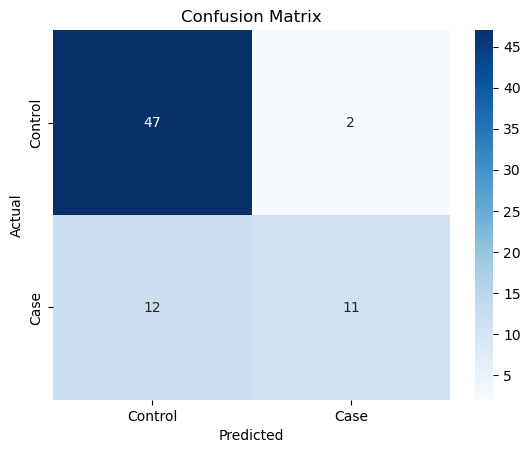

In [25]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Control', 'Case'], yticklabels=['Control', 'Case'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

Accuracy: 0.8055555555555556
F1 Score: 0.6111111111111112
Specificity: 0.9591836734693877
Sensitivity: 0.4782608695652174


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - L1 Feature Selection

In [27]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [28]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [29]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [30]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_final.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_final, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [31]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001566C96D6C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.7416666666666667, F1 Score: 0.4972972972972973, Sensitivity: 0.38333333333333336, Specificity: 0.9208333333333333
Accuracy: 0.7694444444444445

In [32]:
best_trial = min(trials.results, key=lambda x: x['loss'])
print(f"Best Accuracy: {best_trial['accuracy']}")
print(f"Best F1 Score: {-best_trial['loss']}")
print(f"Best Specificity: {best_trial['specificity']}")
print(f"Best Sensitivity: {best_trial['sensitivity']}")

Best Accuracy: 0.8361111111111111
Best F1 Score: 0.7591836734693878
Best Specificity: 0.8666666666666667
Best Sensitivity: 0.775


In [33]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_final.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_507 (Dense)                    │ (None, 96)                  │          19,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_202 (Dropout)                │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_508 (Dense)                    │ (None, 112)                 │          10,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_203 (Dropout)                │ (None, 112)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_509 (Dense)                    │ (None, 96)                  │          10,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_510 (Dense)                    │ (None, 200)                 │          19,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_511 (Dense)                    │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 60,609 (236.75 KB)

 Trainable params: 60,609 (236.75 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
print("\nBest Hyperparameters:")
print(f"Neurons in first layer: {int(best['neurons1'])}")
print(f"Neurons in second layer: {int(best['neurons2'])}")
print(f"Dropout rate: {best['dropout_rate']}")
print(f"Learning rate: {best['learning_rate']}")
print(f"Number of epochs: {int(best['epochs'])}")
print(f"Batch size: {int(best['batch_size'])}")


Best Hyperparameters:
Neurons in first layer: 96
Neurons in second layer: 112
Dropout rate: 0.6964777806391118
Learning rate: 0.013885824533816149
Number of epochs: 100
Batch size: 64


## Bidirectional LSTM with Bayesian Optimization - L1 Feature Selection

In [35]:
def create_rnn_model(input_shape, units=64, bidirectional=False, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if bidirectional:
        model.add(Bidirectional(LSTM(units, return_sequences=False)))
    else:
        model.add(LSTM(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [36]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

In [37]:
space = {
    'units': scope.int(hp.quniform('units', 64, 256, 64)),  # Reduced range for faster evaluation
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.7),  # Reduced range
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),  # Adjusted range
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),  # Reduced number of epochs
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),  # Reduced range
    'bidirectional': hp.choice('bidirectional', [True, False])
}

In [38]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)  
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = KerasClassifier(
            model=create_rnn_model,
            input_shape=(X_final.shape[1], 1),
            units=params['units'],
            bidirectional=params['bidirectional'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
        specificity = tn / (tn + fp)  # True Negative Rate

        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [39]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials
            trials=trials)

Iteration Results - Accuracy: 0.6597222222222223, F1 Score: 0.44649943310657597, Sensitivity: 0.41042510121457493, Specificity: 0.7854423234811166
Iteration Results - Accuracy: 0.5972222222222222, F1 Score: 0.2332220986281053, Sensitivity: 0.2451923076923077, Specificity: 0.7976190476190476
Iteration Results - Accuracy: 0.6423611111111112, F1 Score: 0.35781544256120523, Sensitivity: 0.30246288798920373, Specificity: 0.8100523399014778
Iteration Results - Accuracy: 0.6597222222222222, F1 Score: 0.32621567725111217, Sensitivity: 0.2529942645074224, Specificity: 0.8686986863711001
Iteration Results - Accuracy: 0.6666666666666666, F1 Score: 0.4216545718432511, Sensitivity: 0.3734817813765183, Specificity: 0.8129156403940887
Iteration Results - Accuracy: 0.6805555555555555, F1 Score: 0.3688610240334378, Sensitivity: 0.2847925101214575, Specificity: 0.879377052545156
Iteration Results - Accuracy: 0.7013888888888888, F1 Score: 0.4295340777820562, Sensitivity: 0.3473768556005398, Specificity: 

In [40]:
best_params = {
    'units': int(best['units']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size']),
    'bidirectional': best['bidirectional']
}

print("Best Hyperparameters:", best_params)

# Build and summarize the best model
best_model = create_rnn_model(
    input_shape=(X_final.shape[1], 1),
    units=best_params['units'],
    bidirectional=best_params['bidirectional'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])


Best Hyperparameters: {'units': 192, 'dropout_rate': 0.42919759131658075, 'learning_rate': 0.0003575754385686357, 'epochs': 40, 'batch_size': 16, 'bidirectional': 0}


In [41]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step

Test Performance:
Accuracy: 0.6111111111111112
F1 Score: 0.4166666666666667
Sensitivity: 0.4166666666666667
Specificity: 0.7083333333333334


## GRU with Bayesian Optimization - L1 Feature Selection

In [64]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [65]:
def create_gru_model(input_shape, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(GRU(units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [66]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [67]:
space = {
    'units': scope.int(hp.quniform('units', 64, 128, 64)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 20, 30, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [68]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        model = KerasClassifier(
            model=create_gru_model,
            input_shape=(X_final.shape[1], 1),
            units=params['units'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate'],
            epochs=params['epochs'],
            batch_size=params['batch_size'],
            verbose=0
        )
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_val_pred = model.predict(X_val)
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)
    
    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")
    
    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [69]:
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)

Iteration Results - Accuracy: 0.6597222222222222, F1 Score: 0.022988505747126436, Sensitivity: 0.012820512820512822, Specificity: 0.9904761904761905
Iteration Results - Accuracy: 0.6631944444444443, F1 Score: 0.018018018018018018, Sensitivity: 0.009259259259259259, Specificity: 0.9952380952380953
Iteration Results - Accuracy: 0.6597222222222222, F1 Score: 0.0, Sensitivity: 0.0, Specificity: 0.9952380952380953     
Iteration Results - Accuracy: 0.6527777777777778, F1 Score: 0.03952339436210404, Sensitivity: 0.022344322344322345, Specificity: 0.975487900078064
Iteration Results - Accuracy: 0.6041666666666666, F1 Score: 0.2228189521422604, Sensitivity: 0.18089133089133091, Specificity: 0.8258782201405152
Iteration Results - Accuracy: 0.6076388888888888, F1 Score: 0.24104904016113785, Sensitivity: 0.19318274318274317, Specificity: 0.8264897215716888
Iteration Results - Accuracy: 0.5694444444444445, F1 Score: 0.23241652983032293, Sensitivity: 0.2092999592999593, Specificity: 0.7641556075982

KeyboardInterrupt: 

In [70]:
best_params = space_eval(space, best)  
print("Best Parameters:", best_params)  

Best Parameters: {'batch_size': 16, 'dropout_rate': 0.42919759131658075, 'epochs': 40, 'learning_rate': 0.0003575754385686357, 'units': 192}


In [71]:
best_model = create_gru_model(
    input_shape=(X_final.shape[1], 1),
    units=best_params['units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [72]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
                   loss='binary_crossentropy',
                   metrics=['accuracy'])

In [73]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\ProgramData\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\rnn.py", line 418, in <genexpr>
    output_ta_t = tuple(  File "C:\ProgramData\anaconda3\Lib\site-packages\tensorflow\python\util\tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),


In [74]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 781ms/step

Test Performance:
Accuracy: 0.6666666666666666
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 0.9795918367346939


## CNN with Bayesian Optimization - L1 Feature Selection

In [75]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [76]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [77]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [78]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [79]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [80]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                

Iteration Results - Accuracy: 0.7395833333333334, F1 Score: 0.5653495440729484, Sensitivity: 0.5052910052910052, Specificity: 0.8570778037991152
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step                                         

In [81]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 16, 'dropout_rate': 0.21446610066847818, 'epochs': 30, 'filters': 96, 'kernel_size': 2, 'learning_rate': 0.00016286462532604228}


In [82]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [83]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [84]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


In [85]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.7361111111111112
F1 Score: 0.5581395348837209
Sensitivity: 0.5217391304347826
Specificity: 0.8367346938775511


## ResNet - L1 Feature Selection

In [86]:
X_selected = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [88]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = Conv1D(filters, kernel_size, padding='same', strides=stride)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv1D(filters, kernel_size, padding='same', strides=1)(x)
    x = BatchNormalization()(x)
    
    if stride != 1 or x.shape[-1] != shortcut.shape[-1]:
        shortcut = Conv1D(filters, kernel_size, padding='same', strides=stride)(shortcut)
        shortcut = BatchNormalization()(shortcut)
        
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

In [89]:
def create_resnet_model(input_shape, filters=64, num_blocks=6, kernel_size=3, dropout_rate=0.5, learning_rate=0.001):
    inputs = Input(shape=input_shape)
    x = Conv1D(filters, kernel_size=kernel_size, padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    for _ in range(num_blocks):
        x = residual_block(x, filters, kernel_size=kernel_size)
    
    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [90]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'num_blocks': scope.int(hp.quniform('num_blocks', 4, 10, 2)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 3, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16)),
    'epochs': scope.int(hp.quniform('epochs', 20, 50, 10))
}

In [91]:
def objective(params):
    print(f"Trying params: {params}")
    filters = params['filters']
    num_blocks = params['num_blocks']
    kernel_size = params['kernel_size']
    dropout_rate = params['dropout_rate']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    epochs = params['epochs']
    
    # Create the ResNet model
    model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                filters=filters,
                                num_blocks=num_blocks,
                                kernel_size=kernel_size,
                                dropout_rate=dropout_rate,
                                learning_rate=learning_rate)
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Filters: {filters}, Blocks: {num_blocks}, Kernel Size: {kernel_size}, Dropout: {dropout_rate}, LR: {learning_rate}, Batch Size: {batch_size}, Epochs: {epochs}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [92]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Adjust the number of evaluations
            trials=trials)

Trying params: {'batch_size': 48, 'dropout_rate': 0.2935329271261504, 'epochs': 40, 'filters': 128, 'kernel_size': 3, 'learning_rate': 0.0032275668146971065, 'num_blocks': 4}
Iteration - Loss: 1.4794044494628906, Filters: 128, Blocks: 4, Kernel Size: 3, Dropout: 0.2935329271261504, LR: 0.0032275668146971065, Batch Size: 48, Epochs: 40
Trying params: {'batch_size': 48, 'dropout_rate': 0.2087848429284892, 'epochs': 40, 'filters': 64, 'kernel_size': 4, 'learning_rate': 0.002413192266739897, 'num_blocks': 8}
Iteration - Loss: 4.820839881896973, Filters: 64, Blocks: 8, Kernel Size: 4, Dropout: 0.2087848429284892, LR: 0.002413192266739897, Batch Size: 48, Epochs: 40
Trying params: {'batch_size': 32, 'dropout_rate': 0.2006792344966063, 'epochs': 30, 'filters': 64, 'kernel_size': 4, 'learning_rate': 0.00011725936173243045, 'num_blocks': 6}
Iteration - Loss: 0.5719102025032043, Filters: 64, Blocks: 6, Kernel Size: 4, Dropout: 0.2006792344966063, LR: 0.00011725936173243045, Batch Size: 32, Epoch

In [93]:
best_params = space_eval(space, best)
print(f"Best parameters: {best_params}")

Best parameters: {'batch_size': 32, 'dropout_rate': 0.24824376647502586, 'epochs': 40, 'filters': 96, 'kernel_size': 4, 'learning_rate': 0.00013191036217051784, 'num_blocks': 8}


In [94]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
best_model = create_resnet_model(input_shape=(X_train.shape[1], 1),
                                 filters=best_params['filters'],
                                 num_blocks=best_params['num_blocks'],
                                 kernel_size=best_params['kernel_size'],
                                 dropout_rate=best_params['dropout_rate'],
                                 learning_rate=best_params['learning_rate'])

In [95]:
history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 768ms/step - accuracy: 0.5454 - loss: 0.9524 - val_accuracy: 0.7586 - val_loss: 0.5708
Epoch 2/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 766ms/step - accuracy: 0.6400 - loss: 0.7453 - val_accuracy: 0.7586 - val_loss: 0.4912
Epoch 3/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 769ms/step - accuracy: 0.6042 - loss: 0.7654 - val_accuracy: 0.7931 - val_loss: 0.4850
Epoch 4/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 735ms/step - accuracy: 0.6554 - loss: 0.8139 - val_accuracy: 0.7931 - val_loss: 0.5007
Epoch 5/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 755ms/step - accuracy: 0.6022 - loss: 0.7558 - val_accuracy: 0.3448 - val_loss: 0.9513
Epoch 6/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 756ms/step - accuracy: 0.6392 - loss: 0.6991 - val_accuracy: 0.7586 - val_loss: 0.4708
Epoch 7/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 724ms/step - accuracy: 0.6354 - loss: 0.7578 - val_accuracy: 0.6897 - val_loss: 0.5614
Epoch 8/40
9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 723ms/step - accuracy: 0.6416 - loss: 0.7403 - val_accuracy: 0.7586 - val_loss:

In [96]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step


In [97]:
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.6805555555555556
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


## FNN with Bayesian Optimization - L1 Feature Selection

In [98]:
X_selected = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [100]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [101]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [102]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [103]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.6319741606712341, Params: {'batch_size': 48, 'dropout_rate': 0.25617384247709507, 'epochs': 100, 'learning_rate': 0.00011820831954376469, 'num_layers': 4, 'units': 192}
Iteration - Loss: 0.4308357238769531, Params: {'batch_size': 96, 'dropout_rate': 0.27769528072114236, 'epochs': 90, 'learning_rate': 0.00307149009109058, 'num_layers': 5, 'units': 128}
Iteration - Loss: 0.6044126749038696, Params: {'batch_size': 96, 'dropout_rate': 0.13173607916225102, 'epochs': 100, 'learning_rate': 0.0003282751966822433, 'num_layers': 4, 'units': 96}
Iteration - Loss: 0.4666287899017334, Params: {'batch_size': 80, 'dropout_rate': 0.23691876779868953, 'epochs': 80, 'learning_rate': 0.001150687279969423, 'num_layers': 5, 'units': 256}
Iteration - Loss: 0.5608408451080322, Params: {'batch_size': 80, 'dropout_rate': 0.1645626563014962, 'epochs': 50, 'learning_rate': 2.4884297653787595e-05, 'num_layers': 4, 'units': 192}
Iteration - Loss: 0.33784356713294983, Params: {'batch_size': 32, 

In [104]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.38179753628700475, 'epochs': 60, 'learning_rate': 0.0047226037579883905, 'num_layers': 4, 'units': 128}


In [105]:
best_model = create_fnn_model(input_dim=X_train.shape[1],
                              num_layers=best_params['num_layers'],
                              units=best_params['units'],
                              dropout_rate=best_params['dropout_rate'],
                              learning_rate=best_params['learning_rate'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = best_model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], 
                         validation_split=0.1, callbacks=[early_stopping], verbose=1)

Epoch 1/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.5696 - loss: 7.0750 - val_accuracy: 0.7586 - val_loss: 2.4041
Epoch 2/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - accuracy: 0.5875 - loss: 9.5935 - val_accuracy: 0.7586 - val_loss: 0.5431
Epoch 3/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.6164 - loss: 3.5001 - val_accuracy: 0.5517 - val_loss: 1.2309
Epoch 4/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.5625 - loss: 3.1168 - val_accuracy: 0.7931 - val_loss: 0.4502
Epoch 5/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.6767 - loss: 1.3571 - val_accuracy: 0.7241 - val_loss: 0.4210
Epoch 6/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7059 - loss: 1.4549 - val_accuracy: 0.7931 - val_loss: 0.4573
Epoch 7/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7092 - loss: 0.8972 - val_accuracy: 0.8276 - val_loss: 0.4405
Epoch 8/60
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - accuracy: 0.7392 - loss: 0.9753 - val_accuracy: 0.8621 - val_loss: 0.3780


In [106]:
y_test_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

Test Performance:
Accuracy: 0.7222222222222222
F1 Score: 0.47368421052631576
Sensitivity: 0.391304347826087
Specificity: 0.8775510204081632


## BERT Transformer - L1 Feature Selection

In [107]:
sequences = [' '.join(map(str, row)) for row in X_final]
labels = case_control_info.map({'Control': 0, 'Case': 1}).values

In [108]:
class SNPDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [109]:
def objective(trial):
    # Suggest hyperparameters
    num_train_epochs = trial.suggest_int('num_train_epochs', 2, 3)  # Reduced number of epochs for faster trials
    batch_size = trial.suggest_categorical('batch_size', [16, 32])  # Higher batch sizes might not fit in memory
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 5e-5, log=True)
    max_length = trial.suggest_int('max_length', 128, 256)  # Reduced sequence length

    # Load DistilBERT tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

    # Split the data
    train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)

    # Tokenize the data
    train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length)
    val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length)

    # Create PyTorch Datasets
    train_dataset = SNPDataset(train_encodings, train_labels)
    val_dataset = SNPDataset(val_encodings, val_labels)

    # Define TrainingArguments
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=num_train_epochs,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        warmup_steps=100,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        save_strategy="epoch",
        save_total_limit=1  # Keep only the last checkpoint
    )

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset
    )

    # Train the model
    trainer.train()

    # Evaluate the model
    eval_result = trainer.evaluate(eval_dataset=val_dataset)

    # Return the evaluation metric to be minimized
    return eval_result['eval_loss']

In [110]:
study = optuna.create_study(direction='minimize')

[I 2024-06-24 12:29:40,216] A new study created in memory with name: no-name-954a3013-b234-4336-b0cb-e6afadc45c4e


In [111]:
study.optimize(objective, n_trials=5)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.690983
2,0.696000,0.666139
3,0.680200,0.637593


[I 2024-06-24 12:35:07,327] Trial 0 finished with value: 0.6375933289527893 and parameters: {'num_train_epochs': 3, 'batch_size': 32, 'learning_rate': 1.0994013700656573e-05, 'max_length': 165}. Best is trial 0 with value: 0.6375933289527893.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.709200,0.627864
2,0.671100,0.628534
3,0.642900,0.629585


[I 2024-06-24 12:41:41,558] Trial 1 finished with value: 0.6295846104621887 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 4.9358391564053396e-05, 'max_length': 200}. Best is trial 1 with value: 0.6295846104621887.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.682426
2,0.694800,0.637889


[I 2024-06-24 12:45:19,737] Trial 2 finished with value: 0.63788902759552 and parameters: {'num_train_epochs': 2, 'batch_size': 32, 'learning_rate': 2.7020500224879126e-05, 'max_length': 164}. Best is trial 1 with value: 0.6295846104621887.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,No log,0.666948
2,0.676300,0.637395


[I 2024-06-24 12:49:35,361] Trial 3 finished with value: 0.637395441532135 and parameters: {'num_train_epochs': 2, 'batch_size': 32, 'learning_rate': 2.2552971147589304e-05, 'max_length': 191}. Best is trial 1 with value: 0.6295846104621887.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.674800,0.647223
2,0.662400,0.624523
3,0.640600,0.624695


[I 2024-06-24 12:54:02,371] Trial 4 finished with value: 0.6246950626373291 and parameters: {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 2.1085637445399094e-05, 'max_length': 130}. Best is trial 4 with value: 0.6246950626373291.


In [112]:
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'num_train_epochs': 3, 'batch_size': 16, 'learning_rate': 2.1085637445399094e-05, 'max_length': 130}


In [113]:
best_params = study.best_params

In [114]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [115]:
train_texts, val_texts, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=42)
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=512)
train_dataset = SNPDataset(train_encodings, train_labels)
val_dataset = SNPDataset(val_encodings, val_labels)

In [116]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=best_params['num_train_epochs'],
    per_device_train_batch_size=best_params['batch_size'],
    per_device_eval_batch_size=best_params['batch_size'],
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch",
    learning_rate=best_params['learning_rate']
)

In [117]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

C:\ProgramData\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(


In [118]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.652600,0.643243
2,0.651000,0.633872
3,0.634700,0.630172


TrainOutput(global_step=54, training_loss=0.6487076370804398, metrics={'train_runtime': 2411.4556, 'train_samples_per_second': 0.358, 'train_steps_per_second': 0.022, 'total_flos': 227327951831040.0, 'train_loss': 0.6487076370804398, 'epoch': 3.0})

In [119]:
predictions, labels, _ = trainer.predict(val_dataset)
preds = np.argmax(predictions, axis=1)

# Calculate metrics
accuracy = accuracy_score(val_labels, preds)
f1 = f1_score(val_labels, preds)
conf_matrix = confusion_matrix(val_labels, preds)

# Compute specificity and sensitivity
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.6805555555555556
F1 Score: 0.0
Sensitivity: 0.0
Specificity: 1.0


## Sparse Autoencoder - L1 Feature Selection

In [120]:
X_train, X_val, y_train, y_val= train_test_split(X_final, y, test_size=0.2, random_state=42)

In [121]:
def create_sparse_autoencoder(input_dim, num_units, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(num_units, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer))(input_layer)
    encoder = Dropout(dropout_rate)(encoder)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(inputs=input_layer, outputs=decoder)
    return autoencoder

In [122]:
def objective(trial):
    # Hyperparameters to tune
    num_units = trial.suggest_int('num_units', 64, 256)  # Reduced upper bound
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Lower upper bound
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3)  # Reduced upper bound
    activity_regularizer = trial.suggest_float('activity_regularizer', 1e-7, 1e-4, log=True)  # Reduced range
    batch_size = trial.suggest_int('batch_size', 16, 64)  # Reduced upper bound

    # Create the model
    model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=num_units, dropout_rate=dropout_rate, activity_regularizer=activity_regularizer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=MeanSquaredError())

    # Set early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(X_train, X_train, epochs=50, batch_size=batch_size, validation_data=(X_val, X_val), callbacks=[early_stopping, TFKerasPruningCallback(trial, 'val_loss')], verbose=0)

    # Return the best validation loss
    val_loss = min(history.history['val_loss'])
    return val_loss

In [123]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

[I 2024-06-24 13:35:29,599] A new study created in memory with name: no-name-44a9b9f5-65d0-49ac-ba65-03b587415217
[I 2024-06-24 13:35:43,971] Trial 0 finished with value: 1008.9927368164062 and parameters: {'num_units': 252, 'learning_rate': 0.0003242136054838115, 'dropout_rate': 0.14981295202355663, 'activity_regularizer': 4.038318571974385e-05, 'batch_size': 54}. Best is trial 0 with value: 1008.9927368164062.
[I 2024-06-24 13:36:14,948] Trial 1 finished with value: 1007.5653076171875 and parameters: {'num_units': 132, 'learning_rate': 0.0001595780630329246, 'dropout_rate': 0.06370461274304497, 'activity_regularizer': 7.265614672568357e-07, 'batch_size': 18}. Best is trial 1 with value: 1007.5653076171875.
[I 2024-06-24 13:36:28,710] Trial 2 finished with value: 1007.659912109375 and parameters: {'num_units': 88, 'learning_rate': 0.00018298810196476563, 'dropout_rate': 0.12368337656759679, 'activity_regularizer': 5.324290171152821e-07, 'batch_size': 52}. Best is trial 1 with value: 1

In [124]:
best_params = study.best_params
print("Best Hyperparameters: ", best_params)

Best Hyperparameters:  {'num_units': 220, 'learning_rate': 0.0006183979460694292, 'dropout_rate': 0.23999213160385963, 'activity_regularizer': 1.7264523995100432e-07, 'batch_size': 36}


In [125]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

In [126]:
best_model = create_sparse_autoencoder(input_dim=X_train.shape[1], num_units=best_params['num_units'], dropout_rate=best_params['dropout_rate'], activity_regularizer=best_params['activity_regularizer'])
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss=MeanSquaredError())
best_model.fit(X_train, X_train, epochs=50, batch_size=best_params['batch_size'], validation_data=(X_val, X_val), callbacks=[early_stopping], verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 959.5712 - val_loss: 1016.9202
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1086.3777 - val_loss: 1013.7603
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1125.9893 - val_loss: 1011.5635
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1165.2843 - val_loss: 1010.1290
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1171.9193 - val_loss: 1009.1021
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 997.9229 - val_loss: 1008.2815
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1090.0487 - val_loss: 1007.9968
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1026.1337 - val_loss: 1007.8679
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 1221.3984 - val_loss: 1007.7839
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1001.5286 - val_loss: 1007.7426
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1172.8326 - val_loss: 1007.7372
Epoch 12/50
8/8 ━━━━━

In [127]:
val_loss = best_model.evaluate(X_val, X_val)
print("Validation Loss: ", val_loss)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1032.6028 
Validation Loss:  1007.692626953125


In [128]:
reconstructions = best_model.predict(X_val)
reconstruction_errors = np.mean(np.square(X_val - reconstructions), axis=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [129]:
threshold = np.percentile(reconstruction_errors, 95)
y_pred = (reconstruction_errors > threshold).astype(int)

In [130]:
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

In [131]:
tn, fp, fn, tp = conf_matrix.ravel()
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

Accuracy: 0.6527777777777778
F1 Score: 0.07407407407407407
Sensitivity: 0.043478260869565216
Specificity: 0.9387755102040817


## Stacked Autoencoder & LSTM Model - L1 Feature Selection

In [132]:
X_final = X_final.astype('float32')
y = y.astype('float32')

In [133]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [134]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [135]:
def create_bilstm_model(input_shape, lstm_units, dropout_rate, output_dim):
    inputs = Input(shape=(input_shape[1], input_shape[2]), dtype='float32')
    x = Bidirectional(LSTM(lstm_units, return_sequences=True, dtype='float32'))(inputs)
    x = Dropout(dropout_rate)(x)
    x = Bidirectional(LSTM(lstm_units, dtype='float32'))(x)
    x = Dropout(dropout_rate)(x)
    outputs = Dense(output_dim, activation='sigmoid', dtype='float32')(x)
    model = Model(inputs, outputs)
    return model

In [136]:
def create_stacked_model(X_train, X_val, autoencoder_params, lstm_params):
    input_dim = X_train.shape[1]
    
    # Autoencoder part
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=input_dim,
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(X_train, X_train, epochs=50, batch_size=autoencoder_params['batch_size'], validation_data=(X_val, X_val), verbose=0)

    # Encoder output
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')
    
    # Prepare for LSTM
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # BiLSTM part
    lstm_model = create_bilstm_model(input_shape=X_encoded_train.shape, lstm_units=lstm_params['lstm_units'], dropout_rate=lstm_params['dropout_rate'], output_dim=1)
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    return autoencoder, lstm_model, X_encoded_train, X_encoded_val

In [137]:
def objective(params):
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        autoencoder_params = {
            'encoding_dim': int(params['encoding_dim']),
            'hidden_layers': [int(params['autoencoder_units'])],
            'dropout_rate': params['ae_dropout_rate'],
            'activity_regularizer': params['ae_activity_reg'],
            'learning_rate': params['ae_learning_rate'],
            'batch_size': int(params['ae_batch_size'])
        }
        
        lstm_params = {
            'lstm_units': int(params['lstm_units']),
            'dropout_rate': params['lstm_dropout_rate'],
            'learning_rate': params['lstm_learning_rate'],
            'batch_size': int(params['lstm_batch_size'])
        }

        autoencoder, lstm_model, X_encoded_train, X_encoded_val = create_stacked_model(X_train, X_val, autoencoder_params, lstm_params)

        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        lstm_model.fit(X_encoded_train, y_train, epochs=50, batch_size=lstm_params['batch_size'], validation_data=(X_encoded_val, y_val), callbacks=[early_stopping], verbose=0)
        
        y_val_pred = lstm_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)

        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [138]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'lstm_units': hp.quniform('lstm_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'lstm_dropout_rate': hp.uniform('lstm_dropout_rate', 0.1, 0.5),
    'lstm_learning_rate': hp.loguniform('lstm_learning_rate', np.log(1e-5), np.log(1e-2)),
    'lstm_batch_size': hp.quniform('lstm_batch_size', 16, 64, 1)
}

In [139]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,
            trials=trials)

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step                                                  
2/3 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step                                                  
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step                                                  
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step                                                  

1/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step                                                
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step              

In [140]:
print("Best parameters found: ", best)

Best parameters found:  {'ae_activity_reg': 1.3775768155738399e-07, 'ae_batch_size': 58.0, 'ae_dropout_rate': 0.17218776636186162, 'ae_learning_rate': 0.001953166879248009, 'autoencoder_units': 352.0, 'encoding_dim': 46.0, 'lstm_batch_size': 23.0, 'lstm_dropout_rate': 0.41428187860209265, 'lstm_learning_rate': 0.0001239233199613964, 'lstm_units': 454.0}


In [141]:
best_params = {
    'encoding_dim': best['encoding_dim'],
    'autoencoder_units': best['autoencoder_units'],
    'lstm_units': best['lstm_units'],
    'ae_dropout_rate': best['ae_dropout_rate'],
    'ae_activity_reg': best['ae_activity_reg'],
    'ae_learning_rate': best['ae_learning_rate'],
    'ae_batch_size': best['ae_batch_size'],
    'lstm_dropout_rate': best['lstm_dropout_rate'],
    'lstm_learning_rate': best['lstm_learning_rate'],
    'lstm_batch_size': best['lstm_batch_size']
}

In [142]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [143]:
def train_final_model(X_train, y_train, X_val, y_val, best_params):
    # Extracting autoencoder parameters from the best params
    autoencoder_params = {
        'encoding_dim': int(best_params['encoding_dim']),
        'hidden_layers': [int(best_params['autoencoder_units'])],
        'dropout_rate': best_params['ae_dropout_rate'],
        'activity_regularizer': best_params['ae_activity_reg'],
        'learning_rate': best_params['ae_learning_rate'],
        'batch_size': int(best_params['ae_batch_size'])
    }

    # Extracting BiLSTM parameters from the best params
    lstm_params = {
        'lstm_units': int(best_params['lstm_units']),
        'dropout_rate': best_params['lstm_dropout_rate'],
        'learning_rate': best_params['lstm_learning_rate'],
        'batch_size': int(best_params['lstm_batch_size'])
    }

    # Create the stacked model
    autoencoder, encoder = create_deep_autoencoder(
        input_dim=X_train.shape[1],
        encoding_dim=autoencoder_params['encoding_dim'],
        hidden_layers=autoencoder_params['hidden_layers'],
        dropout_rate=autoencoder_params['dropout_rate'],
        activity_regularizer=autoencoder_params['activity_regularizer']
    )

    # Compile and train the autoencoder
    autoencoder.compile(optimizer=Adam(learning_rate=autoencoder_params['learning_rate']), loss='mse')
    autoencoder.fit(
        X_train, X_train,
        epochs=50,
        batch_size=autoencoder_params['batch_size'],
        validation_data=(X_val, X_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    # Encode the training and validation data
    X_encoded_train = encoder.predict(X_train).astype('float32')
    X_encoded_val = encoder.predict(X_val).astype('float32')

    # Reshape the encoded data for LSTM input
    X_encoded_train = np.expand_dims(X_encoded_train, axis=-1)
    X_encoded_val = np.expand_dims(X_encoded_val, axis=-1)

    # Create and compile the BiLSTM model
    lstm_model = create_bilstm_model(
        input_shape=X_encoded_train.shape,
        lstm_units=lstm_params['lstm_units'],
        dropout_rate=lstm_params['dropout_rate'],
        output_dim=1  # Assuming binary classification
    )
    lstm_model.compile(optimizer=Adam(learning_rate=lstm_params['learning_rate']), loss='binary_crossentropy', metrics=['accuracy'])

    # Train the BiLSTM model
    lstm_model.fit(
        X_encoded_train, y_train,
        epochs=50,
        batch_size=lstm_params['batch_size'],
        validation_data=(X_encoded_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
        verbose=1
    )

    return lstm_model, X_encoded_val

In [144]:
lstm_model, X_encoded_val = train_final_model(X_train_val, y_train_val, X_test, y_test, best_params)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 1071.1632 - val_loss: 1008.3110
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1025.7920 - val_loss: 1007.4958
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1118.7731 - val_loss: 1007.4987
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 1002.4023 - val_loss: 1007.5022
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1119.2770 - val_loss: 1007.5038
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 958.5123 - val_loss: 1007.5042
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 1107.7076 - val_loss: 1007.5042
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5941 - loss: 0.7140 - val_accuracy: 0.6806 - val_loss: 0.6108
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.6411 - loss: 0.6541 - val_accuracy: 0.6806 - val_loss: 0.6186
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step 

In [145]:
y_val_pred = lstm_model.predict(X_encoded_val).flatten()
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_val_pred_binary)
f1 = f1_score(y_test, y_val_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_val_pred_binary).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 798ms/step
Accuracy: 0.6944444444444444
F1 Score: 0.08333333333333333
Sensitivity: 0.043478260869565216
Specificity: 1.0


## Stacked Autoencoder & FNN Model - L1 Feature Selection

In [146]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [147]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [148]:
def ensure_float32(data):
    return data.astype(np.float32)

In [149]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [150]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [151]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [152]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [153]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step                                                  

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step                                                

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step             

In [154]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [155]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [156]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Final Model - Accuracy: 0.6906836055656381
Final Model - F1 Score: 0.41104209799861974
Final Model - Sensitivity: 0.35675475987496447
Final Model - Specificity: 0.8661776469390496


## FNN with Bayesian Optimization - 1500 SNPs

In [5]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_31504\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [6]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [7]:
amgm_values = calculate_amgm(X)

In [8]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [9]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [10]:
X_selected = X[selected_indices, :].T

In [11]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [12]:
X_selected = X_selected.reshape((X_selected.shape[0], X_selected.shape[1], 1))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [14]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [15]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 6, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [16]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [17]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.0006831909995526075, Params: {'batch_size': 64, 'dropout_rate': 0.46043113064620167, 'epochs': 100, 'learning_rate': 0.0019501416402359943, 'num_layers': 4, 'units': 160}
Iteration - Loss: 0.0672718957066536, Params: {'batch_size': 32, 'dropout_rate': 0.20621497324243349, 'epochs': 90, 'learning_rate': 0.00012131541505840523, 'num_layers': 6, 'units': 192}
Iteration - Loss: 0.02383391372859478, Params: {'batch_size': 80, 'dropout_rate': 0.30254993941018166, 'epochs': 100, 'learning_rate': 0.007167925668626116, 'num_layers': 5, 'units': 96}
Iteration - Loss: 0.3445459008216858, Params: {'batch_size': 112, 'dropout_rate': 0.25684880288289214, 'epochs': 90, 'learning_rate': 5.821685804107035e-05, 'num_layers': 4, 'units': 96}
Iteration - Loss: 0.5511950254440308, Params: {'batch_size': 80, 'dropout_rate': 0.31277689307066026, 'epochs': 80, 'learning_rate': 2.6921790646519144e-05, 'num_layers': 2, 'units': 64}
Iteration - Loss: 0.07607342302799225, Params: {'batch_size'

In [18]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 64, 'dropout_rate': 0.4146044486803633, 'epochs': 110, 'learning_rate': 0.0016243086511091884, 'num_layers': 6, 'units': 256}


In [19]:
def evaluate_model_with_kfold(X_selected, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_fnn_model(input_dim=X_train.shape[1],
          num_layers=best_params['num_layers'],
          units=best_params['units'],
          dropout_rate=best_params['dropout_rate'],
          learning_rate=best_params['learning_rate'])
        
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [20]:
evaluate_model_with_kfold(X_train, y_train, best_params, k=5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000018781A98EA0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step

K-Fold Cross-Validation Results:
Accuracy: 0.9826376285541439
F1 Score: 0.9735717373328903
Sensitivity: 0.9799019607843137
Specificity: 0.9843382791399208


## Deep Autoencoder with Optimized Hyperparameters (Bayesian Optimization) - 1500 SNPs

In [23]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_29844\1784159331.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=

In [24]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [25]:
amgm_values = calculate_amgm(X)

In [26]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [27]:
print("Top AMGM feature indices:", top_amgm_indices[:10])  # Print the first 10 indices
print("Top AMGM values:", amgm_values[top_amgm_indices][:10])

Top AMGM feature indices: [575822 114143  71716 499736 767356 750187 514835 412607 468562 385721]
Top AMGM values: [1.00529797 1.0052982  1.00529837 1.00529853 1.00529853 1.00529858
 1.00529869 1.00529874 1.00529877 1.00529877]


In [28]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [22]:
X_selected = X[selected_indices, :].T

In [23]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [24]:
y = case_control_info.map({'Control': 0, 'Case': 1}).values  

In [25]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [27]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_selected.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_selected, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [28]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 0.9916666666666667, F1 Score: 0.9875518672199171, Sensitivity: 0.9916666666666667, Specificity: 0.9916666666666667
Accuracy: 0.9944444444444445, F1 Score: 0.9917355371900827, Sensitivity: 1.0, Specificity: 0.9916666666666667          
Accuracy: 0.9944444444444445, F1 Score: 0.9917355371900827, Sensitivity: 1.0, Specificity: 0.9916666666666667          
Accuracy: 0.9916666666666667, F1 Score: 0.9876543209876543, Sensitivity: 1.0, Specificity: 0.9875                      
Accuracy: 0.9888888888888889, F1 Score: 0.9836065573770492, Sensitivity: 1.0, Specificity: 0.9833333333333333          
Accuracy: 0.9972222222222222, F1 Score: 0.995850622406639, Sensitivity: 1.0, Specificity: 0.9958333333333333           
Accuracy: 0.7694444444444445, F1 Score: 0.484472049689441, Sensitivity: 0.325, Specificity: 0.9916666666666667         
Accuracy: 0.9944444444444445, F1 Sc

In [32]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_141"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_732 (Dense)               │ (None, 160)            │       240,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_379 (Dropout)           │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_733 (Dense)               │ (None, 128)            │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_380 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_734 (Dense)               │ (None, 160)            │        20,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_735 (Dense)               │ (None, 1500)           │       241,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_736 (Dense)               │ (None, 1)              │         1,501 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 524,409 (2.00 MB)

 Trainable params: 524,409 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
def evaluate_model_with_kfold(X_selected, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_deep_autoencoder(
            input_dim=X_selected.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [34]:
evaluate_model_with_kfold(X_selected, y, best_params, k=5)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

K-Fold Cross-Validation Results:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## CNN with Bayesian Optimization - 1500 SNPs

In [4]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_12184\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,25

In [5]:
features_df = df.iloc[:-1, :] 
case_control_info = df.iloc[-1, :]  
y = case_control_info.map({'Control': 0, 'Case': 1}).values  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values

In [6]:
amgm_values = calculate_amgm(X)

In [7]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [8]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [9]:
X_selected = X[selected_indices, :].T

In [10]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [11]:
X_selected = X_selected.reshape(X_selected.shape[0], X_selected.shape[1], 1)  # Add a channel dimension

In [12]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [13]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [14]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [15]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [16]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step                                                

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step                                                

  0%|                                                                           | 0/20 [00:10<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001F7A8375080> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) pa

In [17]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 64, 'dropout_rate': 0.38797275262721775, 'epochs': 50, 'filters': 64, 'kernel_size': 4, 'learning_rate': 0.0012163859995114115}


In [18]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [19]:
def evaluate_model_with_kfold(X_selected, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_selected):
        X_train, X_test = X_selected[train_idx], X_selected[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_cnn_model(
            input_shape=(X_train.shape[1], 1),
            filters=int(best_params['filters']),
            kernel_size=int(best_params['kernel_size']),
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [20]:
evaluate_model_with_kfold(X_selected, y, best_params, k=5)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

K-Fold Cross-Validation Results:
Accuracy: 0.6361111111111111
F1 Score: 0.6847614771748753
Sensitivity: 1.0
Specificity: 0.42283580098706147


## Stacked Autoencoder & FNN Model

In [56]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_35804\1784159331.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(input_file_path, header=

In [57]:
features_df = df.iloc[:-1, :]
case_control_info = df.iloc[-1, :]
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.float32)
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.astype(np.float32)

In [60]:
amgm_values = calculate_amgm(X)

In [61]:
num_features = 10000  # Number of features to select based on AMGM
top_amgm_indices = np.argsort(amgm_values)[-num_features:]

In [62]:
selected_indices = filter_redundant_features(X, top_amgm_indices, threshold=0.9)
selected_indices = selected_indices[:1500] 

In [21]:
X_selected = X[selected_indices, :].T

In [22]:
scaler = StandardScaler()
X_selected = scaler.fit_transform(X_selected)

In [23]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [24]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [25]:
def ensure_float32(data):
    return data.astype(np.float32)

In [26]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [27]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [28]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [29]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [30]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [31]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step                                                 

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step                                                  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step                                                

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step             

In [32]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [33]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [34]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Final Model - Accuracy: 0.9827586206896551
Final Model - F1 Score: 0.9757575757575758
Final Model - Sensitivity: 0.9549019607843137
Final Model - Specificity: 1.0


## Deep Autoencoder - ReliefF

In [3]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_7608\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [4]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.T.astype(np.float32)
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.int32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [5]:
def select_features_relieff(X, y, num_features):
    relief = ReliefF(n_neighbors=100, n_features_to_select=num_features, discrete_threshold=10)
    relief.fit(X, y)
    return relief.top_features_[:num_features]

In [6]:
relieff_indices = select_features_relieff(X_scaled, y, 1000)
X_final = X_scaled[:, relieff_indices]

In [7]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [8]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [9]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_final.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_final, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [10]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]WARNING:tensorflow:5 out of the last 5 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000029C675798A0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
Accuracy: 0.8138888888888889, F1 Score: 0.726530612244898, Sensitivity: 0.7416666666666667, Specificity: 0.85          
  5%|██▍                           

In [11]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_final.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_100"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_500 (Dense)                    │ (None, 64)                  │          64,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_200 (Dropout)                │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_501 (Dense)                    │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_201 (Dropout)                │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_502 (Dense)                    │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_503 (Dense)                    │ (None, 1000)                │          65,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_504 (Dense)                    │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 146,641 (572.82 KB)

 Trainable params: 146,641 (572.82 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
def evaluate_model_with_kfold(X_final, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_final):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_deep_autoencoder(
            input_dim=X_final.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [13]:
evaluate_model_with_kfold(X_final, y, best_params, k=5)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

K-Fold Cross-Validation Results:
Accuracy: 0.8055555555555556
F1 Score: 0.7114899476085459
Sensitivity: 0.7570119352088661
Specificity: 0.8283949837244841


## FNN with Relieff FS

In [14]:
X_final = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [16]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [17]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 8, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 32))
}

In [18]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [19]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.5392817854881287, Params: {'batch_size': 64, 'dropout_rate': 0.2305139686817561, 'epochs': 120, 'learning_rate': 0.005392988248138038, 'num_layers': 5, 'units': 224}
Iteration - Loss: 0.5674105286598206, Params: {'batch_size': 96, 'dropout_rate': 0.3475917324465668, 'epochs': 60, 'learning_rate': 0.00015782702406034666, 'num_layers': 6, 'units': 64}
Iteration - Loss: 0.6019027233123779, Params: {'batch_size': 96, 'dropout_rate': 0.4409050040230378, 'epochs': 110, 'learning_rate': 4.8442749945856976e-05, 'num_layers': 4, 'units': 160}
Iteration - Loss: 0.5617455840110779, Params: {'batch_size': 192, 'dropout_rate': 0.33136532444262795, 'epochs': 60, 'learning_rate': 0.00023214809539519917, 'num_layers': 5, 'units': 64}
Iteration - Loss: 0.5570842027664185, Params: {'batch_size': 64, 'dropout_rate': 0.21117487771778565, 'epochs': 110, 'learning_rate': 0.0014183120582467485, 'num_layers': 5, 'units': 128}
Iteration - Loss: 0.46077120304107666, Params: {'batch_size': 12

In [20]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 128, 'dropout_rate': 0.3994966098541676, 'epochs': 60, 'learning_rate': 8.766266134510066e-05, 'num_layers': 2, 'units': 128}


In [21]:
def evaluate_model_with_kfold(X_final, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_final):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_fnn_model(input_dim=X_train.shape[1],
          num_layers=best_params['num_layers'],
          units=best_params['units'],
          dropout_rate=best_params['dropout_rate'],
          learning_rate=best_params['learning_rate'])
        
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [22]:
evaluate_model_with_kfold(X_train, y_train, best_params, k=5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

K-Fold Cross-Validation Results:
Accuracy: 0.7882032667876587
F1 Score: 0.6445731714697231
Sensitivity: 0.5818286445012787
Specificity: 0.9026795132730869


## CNN with ReliefF

In [23]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [24]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [25]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [26]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [27]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [28]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step                                               

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step                                               

Iteration Results - Accuracy: 0.7465277777777778, F1 Score: 0.711541608448825, Sensitivity: 0.8527472527472527, Specificity: 0.6637522768670311
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step                                               

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step                                            

In [29]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.387593543516464, 'epochs': 30, 'filters': 96, 'kernel_size': 4, 'learning_rate': 0.009537576570493056}


In [30]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [31]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [32]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


In [33]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.8611111111111112
F1 Score: 0.8
Sensitivity: 0.8695652173913043
Specificity: 0.8571428571428571


## Deep Autoencoder & FNN with ReliefF

In [34]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [35]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [36]:
def ensure_float32(data):
    return data.astype(np.float32)

In [37]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [38]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [39]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [40]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [41]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [42]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step                                                

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step             

In [43]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [44]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [45]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Final Model - Accuracy: 0.7361766485178463
Final Model - F1 Score: 0.49395011593154
Final Model - Sensitivity: 0.3983674339300938
Final Model - Specificity: 0.9051221308803639


## Deep Autoencoder with Hybrid FS

In [46]:
input_file_path = 'C:/Research_Summer/FinalizedMentalData.csv'  
df = pd.read_csv(input_file_path, header=0, index_col=0)

C:\Users\colte\AppData\Local\Temp\ipykernel_7608\4034416334.py:2: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255

In [47]:
features_df = df.iloc[:-1, :]  
case_control_info = df.iloc[-1, :]  
X = features_df.apply(pd.to_numeric, errors='coerce').fillna(0).values.T.astype(np.float32)
y = case_control_info.map({'Control': 0, 'Case': 1}).values.astype(np.int32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

In [48]:
def select_features_cmim(X, y, num_features):
    mi_scores = mutual_info_classif(X, y)
    top_indices = np.argsort(mi_scores)[-num_features:]
    return top_indices

In [49]:
def select_features_svm_rfe(X, y, num_features):
    svc = SVC(kernel="linear", C=1)
    rfe = RFE(estimator=svc, n_features_to_select=num_features, step=1)
    rfe.fit(X, y)
    return np.where(rfe.support_)[0]

In [50]:
num_features_cmim = 5000  # Number of features to keep after CMIM
cmim_indices = select_features_cmim(X_scaled, y, num_features_cmim)
X_cmim = X_scaled[:, cmim_indices]

# Second step: Apply SVM-RFE on the reduced feature space from CMIM
num_features_final = 1000  # Number of final features to select
svm_rfe_indices = select_features_svm_rfe(X_cmim, y, num_features_final)
X_final = X_cmim[:, svm_rfe_indices]

print(f"Shape of final selected features: {X_final.shape}")

Shape of final selected features: (360, 1000)


In [51]:
def create_deep_autoencoder(input_dim, neurons1=64, neurons2=32, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    model.add(Dense(neurons1, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons2, activation='sigmoid'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(neurons1, activation='linear'))
    model.add(Dense(input_dim, activation='linear'))
    model.add(Dense(1, activation='sigmoid'))  # Final classification layer
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [52]:
space = {
    'neurons1': scope.int(hp.quniform('neurons1', 32, 256, 32)),
    'neurons2': scope.int(hp.quniform('neurons2', 16, 128, 16)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-1)),
    'epochs': scope.int(hp.quniform('epochs', 50, 200, 50)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 128, 16))
}

In [53]:
def objective(params):
    model = KerasClassifier(
        model=create_deep_autoencoder,
        input_dim=X_final.shape[1],
        neurons1=params['neurons1'],
        neurons2=params['neurons2'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0
    )

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    y_pred = cross_val_predict(model, X_final, y, cv=kfold, method='predict')

    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    sensitivity = tp / (tp + fn)  # True Positive Rate / Recall
    specificity = tn / (tn + fp)  # True Negative Rate

    print(f"Accuracy: {accuracy}, F1 Score: {f1}, Sensitivity: {sensitivity}, Specificity: {specificity}")

    # Return the negative F1 score as Hyperopt minimizes the objective function
    return {'loss': -f1, 'status': STATUS_OK, 'accuracy': accuracy, 'f1': f1, 'sensitivity': sensitivity, 'specificity': specificity}

In [54]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of evaluations to perform
            trials=trials)

print("Best parameters found: ", best)

Accuracy: 0.7777777777777778, F1 Score: 0.5, Sensitivity: 0.3333333333333333, Specificity: 1.0                         
Accuracy: 0.825, F1 Score: 0.6440677966101694, Sensitivity: 0.475, Specificity: 1.0                                    
Accuracy: 0.7583333333333333, F1 Score: 0.43137254901960786, Sensitivity: 0.275, Specificity: 1.0                      
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 0.7305555555555555, F1 Score: 0.32167832167832167, Sensitivity: 0.19166666666666668, Specificity: 1.0        
Accuracy: 0.8722222222222222, F1 Score: 0.7653061224489796, Sensitivity: 0.625, Specificity: 0.9958333333333333        
Accuracy: 0.8722222222222222, F1 Score: 0.7628865979381443, Sensitivity: 0.6166666666666667, Specificity: 1.0          
Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                                       
Accuracy: 1.0, F1 Score: 1.0, Sensitivit

In [55]:
best_params = {
    'neurons1': int(best['neurons1']),
    'neurons2': int(best['neurons2']),
    'dropout_rate': best['dropout_rate'],
    'learning_rate': best['learning_rate'],
    'epochs': int(best['epochs']),
    'batch_size': int(best['batch_size'])
}

best_model = create_deep_autoencoder(
    input_dim=X_selected.shape[1],
    neurons1=best_params['neurons1'],
    neurons2=best_params['neurons2'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model.summary()

Model: "sequential_302"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_1968 (Dense)                   │ (None, 160)                 │         160,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_956 (Dropout)                │ (None, 160)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1969 (Dense)                   │ (None, 48)                  │           7,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_957 (Dropout)                │ (None, 48)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1970 (Dense)                   │ (None, 160)                 │           7,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1971 (Dense)                   │ (None, 1000)                │         161,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1972 (Dense)                   │ (None, 1)                   │           1,001 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 337,729 (1.29 MB)

 Trainable params: 337,729 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
def evaluate_model_with_kfold(X_final, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_final):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_deep_autoencoder(
            input_dim=X_final.shape[1],
            neurons1=best_params['neurons1'],
            neurons2=best_params['neurons2'],
            dropout_rate=best_params['dropout_rate'],
            learning_rate=best_params['learning_rate']
        )
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [57]:
evaluate_model_with_kfold(X_final, y, best_params, k=5)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

K-Fold Cross-Validation Results:
Accuracy: 1.0
F1 Score: 1.0
Sensitivity: 1.0
Specificity: 1.0


## FNN with Hybrid FS

In [58]:
X_final = X_final.reshape((X_final.shape[0], X_final.shape[1], 1))

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [60]:
def create_fnn_model(input_dim, num_layers=2, units=64, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(units, activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))
    
    for _ in range(num_layers - 1):
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [61]:
space = {
    'num_layers': scope.int(hp.quniform('num_layers', 2, 8, 1)),
    'units': scope.int(hp.quniform('units', 64, 256, 32)),
    'dropout_rate': hp.uniform('dropout_rate', 0.1, 0.7),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-5), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 50, 150, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 32, 256, 32))
}

In [62]:
def objective(params):
    # Create the FNN model with given hyperparameters
    model = create_fnn_model(input_dim=X_train.shape[1], 
                             num_layers=params['num_layers'], 
                             units=params['units'], 
                             dropout_rate=params['dropout_rate'], 
                             learning_rate=params['learning_rate'])
    
    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=params['epochs'], batch_size=params['batch_size'], 
                        validation_split=0.1, callbacks=[early_stopping], verbose=0)
    
    # Evaluate the model
    val_loss = min(history.history['val_loss'])
    
    print(f"Iteration - Loss: {val_loss}, Params: {params}")
    
    return {'loss': val_loss, 'status': STATUS_OK}

In [63]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=30,  # Number of evaluations (trials)
            trials=trials)

  0%|                                                                           | 0/30 [00:00<?, ?trial/s, best loss=?]

C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Iteration - Loss: 0.518062174320221, Params: {'batch_size': 160, 'dropout_rate': 0.654541167150063, 'epochs': 60, 'learning_rate': 0.0003865198781812694, 'num_layers': 3, 'units': 160}
Iteration - Loss: 1.5398871937577496e-06, Params: {'batch_size': 224, 'dropout_rate': 0.639959408572373, 'epochs': 130, 'learning_rate': 0.0034038761416552506, 'num_layers': 2, 'units': 224}
Iteration - Loss: 0.5749499201774597, Params: {'batch_size': 96, 'dropout_rate': 0.50593475204705, 'epochs': 100, 'learning_rate': 0.0001838398825900366, 'num_layers': 4, 'units': 128}
Iteration - Loss: 0.6111588478088379, Params: {'batch_size': 128, 'dropout_rate': 0.5642942294081685, 'epochs': 60, 'learning_rate': 0.005791357327269146, 'num_layers': 7, 'units': 128}
Iteration - Loss: 0.6056633591651917, Params: {'batch_size': 256, 'dropout_rate': 0.4110225361112565, 'epochs': 120, 'learning_rate': 0.00020997897664116935, 'num_layers': 5, 'units': 96}
Iteration - Loss: 0.5763715505599976, Params: {'batch_size': 96, 

In [64]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 96, 'dropout_rate': 0.112981754573242, 'epochs': 140, 'learning_rate': 0.004216124627997179, 'num_layers': 8, 'units': 224}


In [65]:
def evaluate_model_with_kfold(X_final, y, best_params, k=5):
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    
    accuracies = []
    f1_scores = []
    sensitivities = []
    specificities = []

    for train_idx, test_idx in kfold.split(X_final):
        X_train, X_test = X_final[train_idx], X_final[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        # Create and compile the model
        best_model = create_fnn_model(input_dim=X_train.shape[1],
          num_layers=best_params['num_layers'],
          units=best_params['units'],
          dropout_rate=best_params['dropout_rate'],
          learning_rate=best_params['learning_rate'])
        
        best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), 
                           loss='binary_crossentropy', 
                           metrics=['accuracy'])
        
        # Train the model
        best_model.fit(X_train, y_train, 
                       epochs=best_params['epochs'], 
                       batch_size=best_params['batch_size'], 
                       verbose=0)
        
        # Predict on test data
        y_test_pred = best_model.predict(X_test)
        y_test_pred_binary = (y_test_pred > 0.5).astype(int)
        
        # Calculate performance metrics
        accuracy = accuracy_score(y_test, y_test_pred_binary)
        f1 = f1_score(y_test, y_test_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Store the metrics
        accuracies.append(accuracy)
        f1_scores.append(f1)
        sensitivities.append(sensitivity)
        specificities.append(specificity)
    
    # Average the metrics over all folds
    avg_accuracy = np.mean(accuracies)
    avg_f1 = np.mean(f1_scores)
    avg_sensitivity = np.mean(sensitivities)
    avg_specificity = np.mean(specificities)
    
    print("\nK-Fold Cross-Validation Results:")
    print(f"Accuracy: {avg_accuracy}")
    print(f"F1 Score: {avg_f1}")
    print(f"Sensitivity: {avg_sensitivity}")
    print(f"Specificity: {avg_specificity}")

In [66]:
evaluate_model_with_kfold(X_train, y_train, best_params, k=5)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


C:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step

K-Fold Cross-Validation Results:
Accuracy: 0.9965517241379309
F1 Score: 0.9957446808510639
Sensitivity: 0.9916666666666668
Specificity: 1.0


## CNN with Hybrid FS

In [67]:
X_selected = X_final.reshape(X_final.shape[0], X_final.shape[1], 1)  # Add a channel dimension

In [68]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [69]:
def create_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.3, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Conv1D(filters=filters * 2, kernel_size=kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [70]:
space = {
    'filters': scope.int(hp.quniform('filters', 32, 128, 32)),
    'kernel_size': scope.int(hp.quniform('kernel_size', 2, 5, 1)),
    'dropout_rate': hp.uniform('dropout_rate', 0.2, 0.5),
    'learning_rate': hp.loguniform('learning_rate', np.log(1e-4), np.log(1e-2)),
    'epochs': scope.int(hp.quniform('epochs', 30, 50, 10)),
    'batch_size': scope.int(hp.quniform('batch_size', 16, 64, 16))
}

In [71]:
def objective(params):
    # Create a K-Fold cross-validator
    kfold = KFold(n_splits=3, shuffle=True, random_state=42)
    
    # Placeholder for cross-validation results
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []

    for train_idx, val_idx in kfold.split(X_train_val, y_train_val):
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]

        # Create the model with given hyperparameters
        model = create_cnn_model(
            input_shape=(X_selected.shape[1], 1),
            filters=params['filters'],
            kernel_size=params['kernel_size'],
            dropout_rate=params['dropout_rate'],
            learning_rate=params['learning_rate']
        )
        
        # Early stopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) 
        
        # Fit the model
        model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=params['epochs'], batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
        
        # Predict on validation data
        y_val_pred = model.predict(X_val)
        
        # Convert predictions to binary using a threshold of 0.5
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)
        
        # Calculate metrics for this fold
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        # Append metrics
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    # Calculate average metrics across folds
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Iteration Results - Accuracy: {avg_accuracy}, F1 Score: {avg_f1}, Sensitivity: {avg_sensitivity}, Specificity: {avg_specificity}")

    return {'loss': -avg_f1, 'status': STATUS_OK, 'accuracy': avg_accuracy, 'f1': avg_f1, 'sensitivity': avg_sensitivity, 'specificity': avg_specificity}

In [72]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=20,  # Number of trials, adjust based on your needs
            trials=trials)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step                                               
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step                                                

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step                                               
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step                                                

Iteration Results - Accuracy: 1.0, F1 Score: 1.0, Sensitivity: 1.0, Specificity: 1.0                                   
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step                                               
2/3 ━━━━━━━━━━━━━━━━

In [73]:
best_params = space_eval(space, best)
print(f"Best Hyperparameters: {best_params}")

Best Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2216991815117976, 'epochs': 40, 'filters': 128, 'kernel_size': 5, 'learning_rate': 0.0013882482760096432}


In [74]:
best_model = create_cnn_model(
    input_shape=(X_selected.shape[1], 1),
    filters=best_params['filters'],
    kernel_size=best_params['kernel_size'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

In [75]:
best_model.fit(X_train_val, y_train_val, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=0)

In [76]:
y_test_pred = best_model.predict(X_test)
y_test_pred_binary = (y_test_pred > 0.5).astype(int)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


In [77]:
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_f1 = f1_score(y_test, y_test_pred_binary)
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_binary).ravel()
test_sensitivity = tp / (tp + fn)
test_specificity = tn / (tn + fp)

print("\nTest Performance:")
print(f"Accuracy: {test_accuracy}")
print(f"F1 Score: {test_f1}")
print(f"Sensitivity: {test_sensitivity}")
print(f"Specificity: {test_specificity}")


Test Performance:
Accuracy: 0.7222222222222222
F1 Score: 0.696969696969697
Sensitivity: 1.0
Specificity: 0.5918367346938775


## Deep Autoencoder & FNN with Hybrid FS

In [78]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

In [79]:
X_train_val = X_train_val.astype(np.float32)
y_train_val = y_train_val.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

In [80]:
def ensure_float32(data):
    return data.astype(np.float32)

In [81]:
def create_deep_autoencoder(input_dim, encoding_dim, hidden_layers, dropout_rate, activity_regularizer):
    input_layer = Input(shape=(input_dim,), dtype='float32')
    x = input_layer
    for units in hidden_layers:
        x = Dense(units, activation='relu', dtype='float32')(x)
    encoder = Dense(encoding_dim, activation='relu', activity_regularizer=tf.keras.regularizers.l1(activity_regularizer), dtype='float32')(x)
    encoder = Dropout(dropout_rate)(encoder)

    # Decoder
    x = encoder
    for units in reversed(hidden_layers):
        x = Dense(units, activation='relu', dtype='float32')(x)
    decoder = Dense(input_dim, activation='sigmoid', dtype='float32')(x)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, encoder)
    return autoencoder, encoder_model

In [82]:
class AutoencoderTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, autoencoder_params):
        self.autoencoder_params = autoencoder_params
        self.encoder = None

    def fit(self, X, y=None):
        X = ensure_float32(X)
        autoencoder, encoder = create_deep_autoencoder(
            input_dim=X.shape[1],
            encoding_dim=int(self.autoencoder_params['encoding_dim']),
            hidden_layers=[int(self.autoencoder_params['autoencoder_units'])],
            dropout_rate=self.autoencoder_params['ae_dropout_rate'],
            activity_regularizer=self.autoencoder_params['ae_activity_reg']
        )
        autoencoder.compile(optimizer=Adam(learning_rate=self.autoencoder_params['ae_learning_rate']), loss='mse')
        autoencoder.fit(X, X, epochs=50, batch_size=int(self.autoencoder_params['ae_batch_size']), verbose=0)
        self.encoder = encoder
        return self

    def transform(self, X):
        X = ensure_float32(X)
        return self.encoder.predict(X).astype(np.float32)

In [83]:
def create_fnn_model(input_dim, fnn_units, dropout_rate, learning_rate):
    input_layer = Input(shape=(input_dim,))
    x = Dense(fnn_units, activation='relu')(input_layer)
    x = Dropout(dropout_rate)(x)
    output_layer = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [84]:
def objective(params):
    autoencoder_params = {
        'encoding_dim': int(params['encoding_dim']),
        'autoencoder_units': int(params['autoencoder_units']),
        'ae_dropout_rate': params['ae_dropout_rate'],
        'ae_activity_reg': params['ae_activity_reg'],
        'ae_learning_rate': params['ae_learning_rate'],
        'ae_batch_size': int(params['ae_batch_size'])
    }
    
    fnn_params = {
        'fnn_units': int(params['fnn_units']),
        'fnn_dropout_rate': params['fnn_dropout_rate'],
        'fnn_learning_rate': params['fnn_learning_rate'],
        'fnn_batch_size': int(params['fnn_batch_size'])
    }

    autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
    fnn_classifier = KerasClassifier(
        model=create_fnn_model,
        input_dim=int(autoencoder_params['encoding_dim']),
        fnn_units=fnn_params['fnn_units'],
        dropout_rate=fnn_params['fnn_dropout_rate'],
        learning_rate=fnn_params['fnn_learning_rate'],
        epochs=50,
        batch_size=fnn_params['fnn_batch_size'],
        verbose=0
    )

    pipeline = Pipeline([
        ('autoencoder', autoencoder_transformer),
        ('fnn', fnn_classifier)
    ])

    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    results = cross_val_score(pipeline, X_train_val, y_train_val, cv=kfold, scoring='accuracy')

    return {'loss': -np.mean(results), 'status': STATUS_OK}

In [85]:
space = {
    'encoding_dim': hp.quniform('encoding_dim', 10, 100, 1),
    'autoencoder_units': hp.quniform('autoencoder_units', 50, 500, 1),
    'ae_dropout_rate': hp.uniform('ae_dropout_rate', 0.1, 0.5),
    'ae_activity_reg': hp.loguniform('ae_activity_reg', np.log(1e-7), np.log(1e-2)),
    'ae_learning_rate': hp.loguniform('ae_learning_rate', np.log(1e-5), np.log(1e-2)),
    'ae_batch_size': hp.quniform('ae_batch_size', 16, 64, 1),
    'fnn_units': hp.quniform('fnn_units', 50, 500, 1),
    'fnn_dropout_rate': hp.uniform('fnn_dropout_rate', 0.1, 0.5),
    'fnn_learning_rate': hp.loguniform('fnn_learning_rate', np.log(1e-5), np.log(1e-2)),
    'fnn_batch_size': hp.quniform('fnn_batch_size', 16, 64, 1)
}

In [86]:
trials = Trials()
best_params = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=20, trials=trials)
print("Best parameters: ", best_params)

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step                                                  

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                

1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step                                                
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step                                                 

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step                                                
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step              

In [87]:
best_params = {k: (int(v) if 'batch_size' in k or 'units' in k or 'encoding_dim' in k else float(v)) for k, v in best_params.items()}

In [88]:
def train_and_evaluate_final_model(X, y, best_params):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_f1_scores = []
    fold_sensitivities = []
    fold_specificities = []
    
    for train_idx, val_idx in kfold.split(X, y):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        autoencoder_params = {
            'encoding_dim': best_params['encoding_dim'],
            'autoencoder_units': best_params['autoencoder_units'],
            'ae_dropout_rate': best_params['ae_dropout_rate'],
            'ae_activity_reg': best_params['ae_activity_reg'],
            'ae_learning_rate': best_params['ae_learning_rate'],
            'ae_batch_size': best_params['ae_batch_size']
        }
        
        fnn_params = {
            'fnn_units': best_params['fnn_units'],
            'fnn_dropout_rate': best_params['fnn_dropout_rate'],
            'fnn_learning_rate': best_params['fnn_learning_rate'],
            'fnn_batch_size': best_params['fnn_batch_size']
        }
        
        # Train the autoencoder
        autoencoder_transformer = AutoencoderTransformer(autoencoder_params=autoencoder_params)
        autoencoder_transformer.fit(X_train)
        
        # Encode the training and validation data
        X_encoded_train = autoencoder_transformer.transform(X_train)
        X_encoded_val = autoencoder_transformer.transform(X_val)

        # Train the FNN on encoded data
        fnn_model = create_fnn_model(
            input_dim=X_encoded_train.shape[1],
            fnn_units=fnn_params['fnn_units'],
            dropout_rate=fnn_params['fnn_dropout_rate'],
            learning_rate=fnn_params['fnn_learning_rate']
        )
        
        fnn_model.fit(
            X_encoded_train, y_train,
            epochs=50,
            batch_size=fnn_params['fnn_batch_size'],
            validation_data=(X_encoded_val, y_val),
            callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
            verbose=0
        )

        # Predict on validation data
        y_val_pred = fnn_model.predict(X_encoded_val).flatten()
        y_val_pred_binary = (y_val_pred > 0.5).astype(int)

        # Calculate metrics
        accuracy = accuracy_score(y_val, y_val_pred_binary)
        f1 = f1_score(y_val, y_val_pred_binary)
        tn, fp, fn, tp = confusion_matrix(y_val, y_val_pred_binary).ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        fold_accuracies.append(accuracy)
        fold_f1_scores.append(f1)
        fold_sensitivities.append(sensitivity)
        fold_specificities.append(specificity)
    
    avg_accuracy = np.mean(fold_accuracies)
    avg_f1 = np.mean(fold_f1_scores)
    avg_sensitivity = np.mean(fold_sensitivities)
    avg_specificity = np.mean(fold_specificities)

    print(f"Final Model - Accuracy: {avg_accuracy}")
    print(f"Final Model - F1 Score: {avg_f1}")
    print(f"Final Model - Sensitivity: {avg_sensitivity}")
    print(f"Final Model - Specificity: {avg_specificity}")

In [89]:
train_and_evaluate_final_model(X_train_val, y_train_val, best_params)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Final Model - Accuracy: 0.787719298245614
Final Model - F1 Score: 0.5638641315111904
Final Model - Sensitivity: 0.5163725490196078
Final Model - Specificity: 0.9408430713792564
